Записки психа))
составим план

   построить простейшую линейную модель с минимальной предобработкой и без генерации фичей, потом от этого плясать...
   было бы неплохо все же коммитить каждую версию тетрадки, чтобы не потерять результаты и не6 забыть метрики, возможно стоит создать сводную таблицу с версией тетрадки и какую метрику она дала, чтобы было проще откатиться сразу на нужный коммит...
   опробовать нормализацию библиотеки adjdatatools...
   не забыться поиграть с понижением размерности и tSNE? чтобы добавить фичу по кластеру...
   провести тщательный EDA...
   
Цель - f-score выше 0.66)))))

# Оглавление

#### 1. Импорт библиотек и оптимизация памяти
#### 2. EDA
#### 3. Обрабртка выбросов
#### 4. Заполнение пропусков и баллансировка классов
#### 5. Генерация новых признаков
#### 6. Отбор признаков
#### 7. Построение модели
#### 8. Предсказание на тесте

## 1. Импорт библиотек и оптимизация памяти

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score, precision_score)
from scipy.stats import shapiro, probplot, mannwhitneyu, chi2_contingency

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from adjdatatools.preprocessing import AdjustedScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
import featuretools as ft
import featuretools.variable_types as vtypes
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, BaggingClassifier, \
GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingRegressor

from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
matplotlib.rcParams.update({'font.size': 10})

In [3]:
import warnings
warnings.filterwarnings('ignore')

Загрузим данные соревнования с Kaggle

In [4]:
#api = KaggleApi()
#api.authenticate()
#api.competition_download_files('gb-credit-default')

In [5]:
dataset_zip = zipfile.ZipFile('./gb-credit-default.zip')
dataset_zip.extractall()

Прописываем пути к данным

In [6]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
SAMPLE_SUBMISSION_DATASET_PATH = './sample_submission.csv'

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head(10)

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   
5           Rent            NaN              7 years        0.0   
6  Home Mortgage      1511108.0            10+ years        0.0   
7           Rent      1040060.0            10+ years        0.0   
8  Home Mortgage            NaN              5 years        0.0   
9  Home Mortgage            NaN               1 year        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   
5                     12.0                     14.6             366784.0   
6                      9.0                     20.3             388124.0   
7                     13.0                     12.0             330374.0   
8                     17.0                     15.7                  0.0   
9                     10.0                     24.6             511302.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   
5                        0.0                           NaN           0.0   
6                        0.0                          73.0           0.0   
7                        0.0                          18.0           0.0   
8                        1.0                           NaN           1.0   
9                        0.0                           6.0           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   
5               other   Long Term             337304.0   
6   home improvements  Short Term           99999999.0   
7               other  Short Term             250888.0   
8   home improvements  Short Term             129734.0   
9  debt consolidation   Long Term             572880.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0  
5                165680.0       18692.0           NaN               1  
6                 51623.0        2317.0         745.0               0  
7                 89015.0       19761.0         705.0               1  
8                    19.0          17.0           NaN               0  
9                205333.0       17613.0           NaN               1

In [8]:
train_df.shape

(7500, 17)

In [9]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [10]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [11]:
test_df.head(7)

Home Ownership  Annual Income Years in current job  Tax Liens  \
0           Rent            NaN              4 years        0.0   
1           Rent       231838.0               1 year        0.0   
2  Home Mortgage      1152540.0              3 years        0.0   
3  Home Mortgage      1220313.0            10+ years        0.0   
4  Home Mortgage      2340952.0              6 years        0.0   
5  Home Mortgage       922583.0              5 years        0.0   
6  Home Mortgage      1233309.0              3 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   
5                     26.0                     17.5             713174.0   
6                      7.0                     22.0             376420.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        0.0                          70.0           0.0   
1                        0.0                           8.0           0.0   
2                        0.0                           NaN           0.0   
3                        0.0                          70.0           0.0   
4                        0.0                           NaN           0.0   
5                        0.0                          41.0           0.0   
6                        0.0                          43.0           0.0   

                Purpose        Term  Current Loan Amount  \
0    debt consolidation  Short Term             162470.0   
1  educational expenses  Short Term              78298.0   
2    debt consolidation  Short Term             200178.0   
3    debt consolidation  Short Term             217382.0   
4    debt consolidation   Long Term             777634.0   
5    debt consolidation  Short Term              94028.0   
6     home improvements  Short Term             454388.0   

   Current Credit Balance  Monthly Debt  Credit Score  
0                105906.0        6813.0           NaN  
1                 46037.0        2318.0         699.0  
2                146490.0       18729.0        7260.0  
3                213199.0       27559.0         739.0  
4                425391.0       42605.0         706.0  
5                135508.0       11148.0         679.0  
6                292904.0        8181.0         685.0

In [12]:
def int_to_str(X):
    
    col = ['Home Ownership',
           'Years in current job',
           'Tax Liens',
           'Number of Credit Problems',
           'Bankruptcies',
           'Purpose',
           'Term']
    X[col] = X[col].astype(str)
    
    return X

In [13]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [14]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

## 2. EDA

In [15]:
train_df.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   5.943000e+03  7500.000000              7500.000000   
mean    1.366392e+06     0.030133                11.130933   
std     8.453392e+05     0.271604                 4.908924   
min     1.645970e+05     0.000000                 2.000000   
25%     8.443410e+05     0.000000                 8.000000   
50%     1.168386e+06     0.000000                10.000000   
75%     1.640137e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317467         9.451537e+05   
std                   7.041946         1.602622e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.935015e+05   
max                  57.700000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                7500.000000                   3419.000000   7486.000000   
mean                    0.170000                     34.692600      0.117152   
std                     0.498598                     21.688806      0.347192   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         7.500000e+03            7.500000e+03    7500.000000   
mean          1.187318e+07            2.898332e+05   18314.454133   
std           3.192612e+07            3.178714e+05   11926.764673   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.801690e+05            1.142565e+05   10067.500000   
50%           3.095730e+05            2.093230e+05   16076.500000   
75%           5.198820e+05            3.604062e+05   23818.000000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   5943.000000     7500.000000  
mean    1151.087498        0.281733  
std     1604.451418        0.449874  
min      585.000000        0.000000  
25%      711.000000        0.000000  
50%      731.000000        0.000000  
75%      743.000000        1.000000  
max     7510.000000        1.000000

In [16]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [17]:
def value_def(x):
    val_series = train_df[x].value_counts()
    return val_series

In [18]:
value_def('Home Ownership')

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [19]:
value_def('Years in current job')

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [20]:
value_def('Tax Liens')

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [21]:
value_def('Number of Open Accounts')

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
35.0      1
41.0      1
38.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

In [22]:
value_def('Years of Credit History')

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.2      1
4.9       1
39.5      1
42.4      1
39.8      1
Name: Years of Credit History, Length: 408, dtype: int64

In [23]:
value_def('Months since last delinquent')

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [24]:
value_def('Number of Credit Problems')

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [25]:
value_def('Bankruptcies')

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [26]:
value_def('Purpose')

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [27]:
value_def('Term')

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [28]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])

In [29]:
df_num_features

Annual Income  Tax Liens  Number of Open Accounts  \
0          482087.0        0.0                     11.0   
1         1025487.0        0.0                     15.0   
2          751412.0        0.0                     11.0   
3          805068.0        0.0                      8.0   
4          776264.0        0.0                     13.0   
...             ...        ...                      ...   
7495       402192.0        0.0                      3.0   
7496      1533984.0        0.0                     10.0   
7497      1878910.0        0.0                     12.0   
7498            NaN        0.0                     21.0   
7499            NaN        0.0                      8.0   

      Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
0                        26.3             685960.0                        1.0   
1                        15.3            1181730.0                        0.0   
2                        35.0            1182434.0                        0.0   
3                        22.5             147400.0                        1.0   
4                        13.6             385836.0                        1.0   
...                       ...                  ...                        ...   
7495                      8.5             107866.0                        0.0   
7496                     26.5             686312.0                        0.0   
7497                     32.1            1778920.0                        0.0   
7498                     26.5            1141250.0                        0.0   
7499                      9.4             480832.0                        0.0   

      Months since last delinquent  Bankruptcies  Current Loan Amount  \
0                              NaN           1.0           99999999.0   
1                              NaN           0.0             264968.0   
2                              NaN           0.0           99999999.0   
3                              NaN           1.0             121396.0   
4                              NaN           0.0             125840.0   
...                            ...           ...                  ...   
7495                           NaN           0.0             129360.0   
7496                          43.0           0.0             444048.0   
7497                           NaN           0.0           99999999.0   
7498                           NaN           0.0             615274.0   
7499                           NaN           0.0              26928.0   

      Current Credit Balance  Monthly Debt  Credit Score  
0                    47386.0        7914.0         749.0  
1                   394972.0       18373.0         737.0  
2                   308389.0       13651.0         742.0  
3                    95855.0       11338.0         694.0  
4                    93309.0        7180.0         719.0  
...                      ...           ...           ...  
7495                 73492.0        1900.0         697.0  
7496                456399.0       12783.0        7410.0  
7497                477812.0       12479.0         748.0  
7498                476064.0       37118.0           NaN  
7499                288192.0        9061.0           NaN  

[7500 rows x 12 columns]

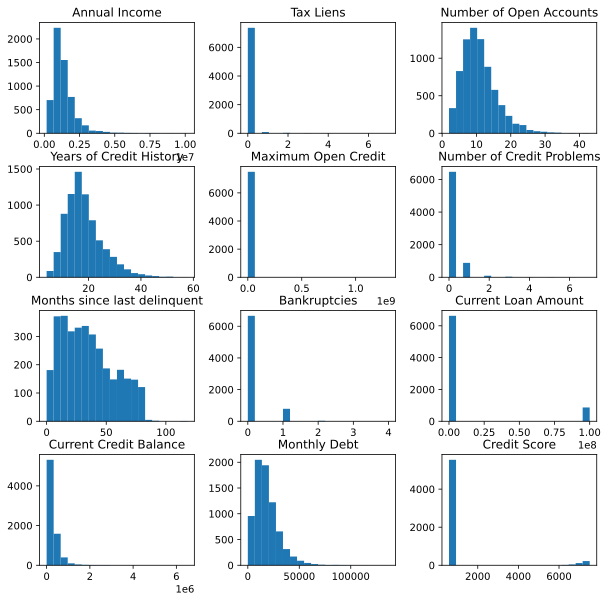

In [30]:
df_num_features.hist(figsize=(10,10), bins=20, grid=False);

In [31]:
TARGET_NAME = train_df['Credit Default']

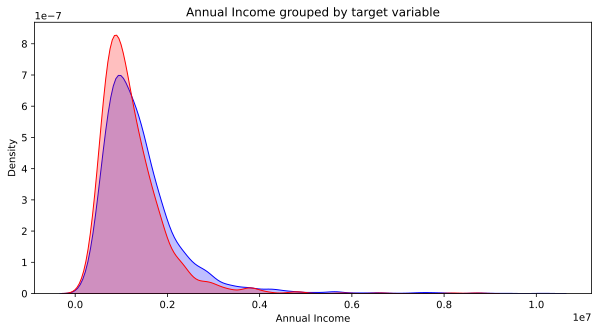

In [32]:
annual_income_with_target = train_df[['Annual Income', 'Credit Default']]
annual_income = annual_income_with_target['Annual Income']
annual_income_target_0 = annual_income[annual_income_with_target['Credit Default'] == 0]
annual_income_target_1 = annual_income[annual_income_with_target['Credit Default'] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_income_target_0, shade=True, label='Нет просрочки', color='b')
sns.kdeplot(annual_income_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

In [33]:
NUM_FEATURE_NAMES = ["', '".join(df_num_features.columns)]
NUM_FEATURE_NAMES

["Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score"]

In [34]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Months since last delinquent', 
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 
                     'Purpose', 'Term']

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


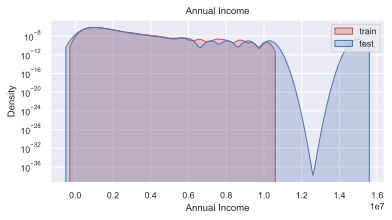

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


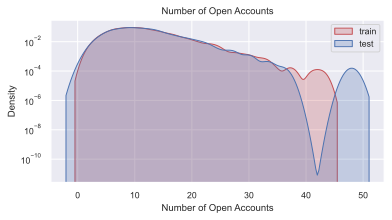

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


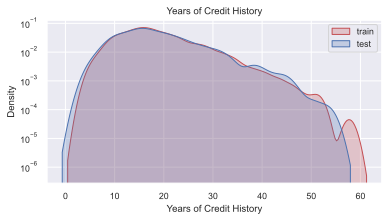

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


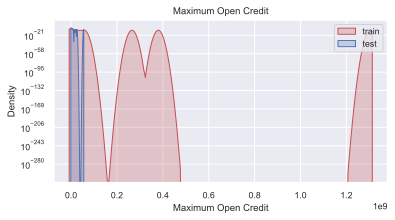

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


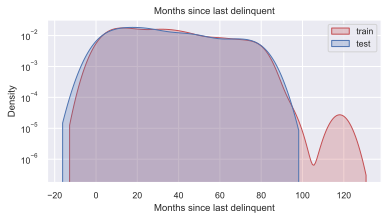

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


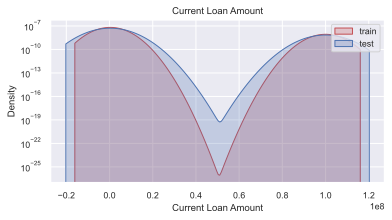

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


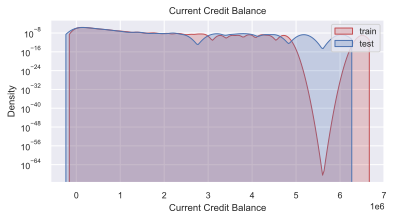

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


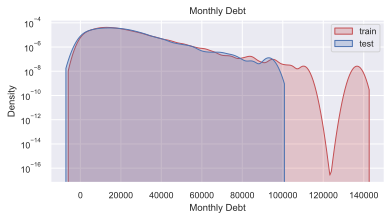

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


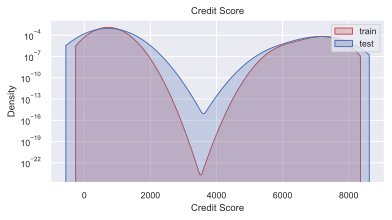

In [35]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='b')
    print(col)
    print(mannwhitneyu(train_df[col], test_df[col]))
    plt.yscale('log')
    plt.legend()
    plt.title(col)
    plt.show()

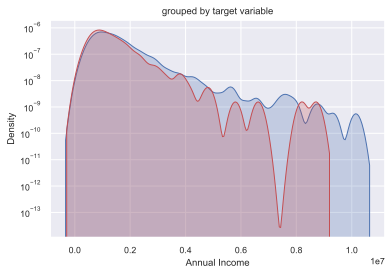

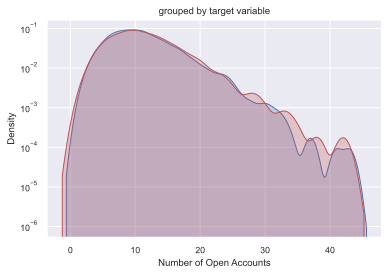

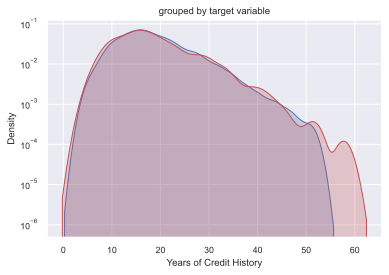

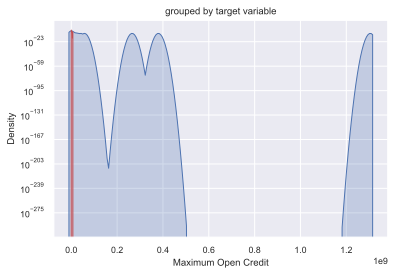

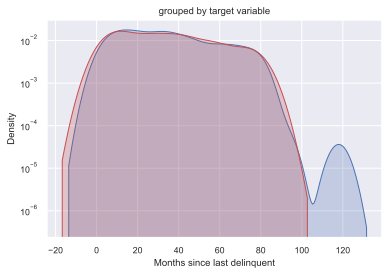

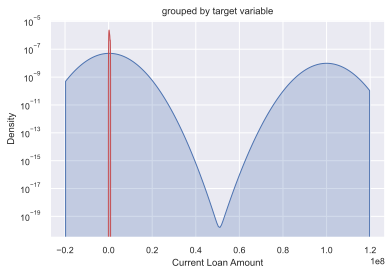

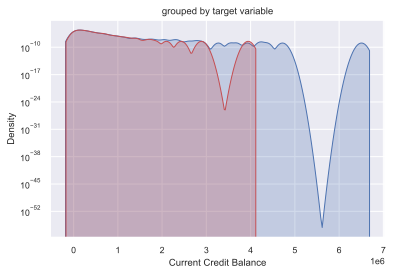

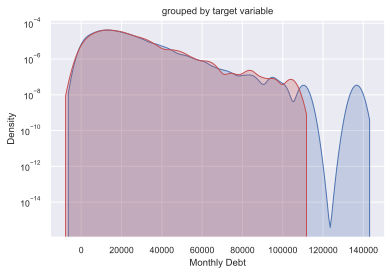

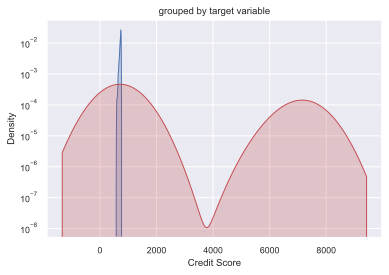

In [36]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    feature_with_target = train_df[[col, 'Credit Default']]
    feature = feature_with_target[col]
    feature_target_0 = feature[feature_with_target['Credit Default'] == 0]
    feature_target_1 = feature[feature_with_target['Credit Default'] == 1]

    #plt.figure(figsize=(10, 5))

    sns.kdeplot(feature_target_0, shade=True, label='Нет просрочки', color='b')
    sns.kdeplot(feature_target_1, shade=True, label='Просрочка', color='r')

    plt.yscale('log')
    plt.xlabel(col)
    plt.title('grouped by target variable')
    plt.show()

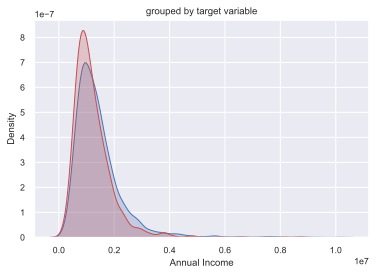

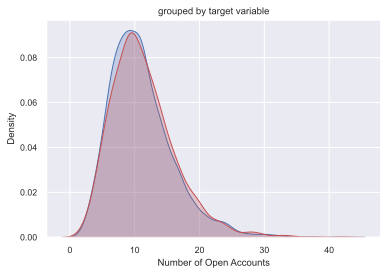

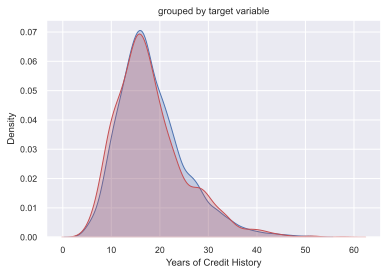

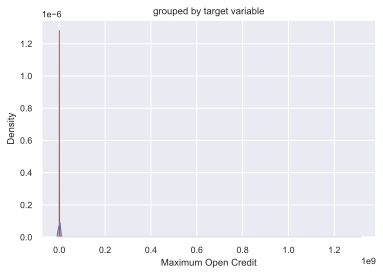

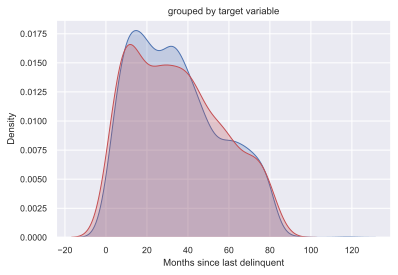

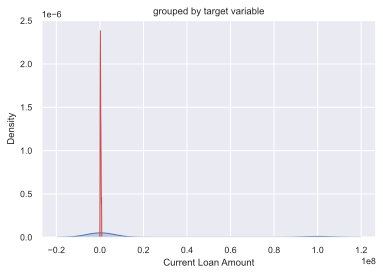

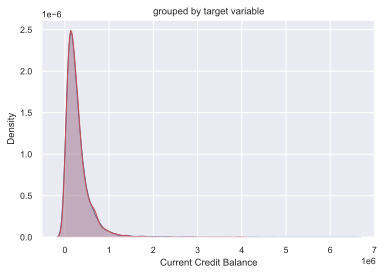

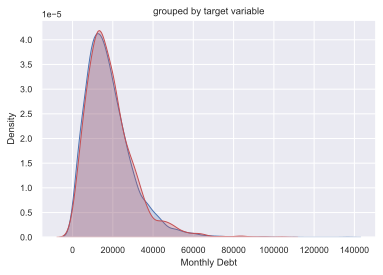

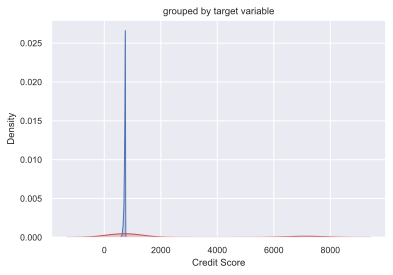

In [37]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    feature_with_target = train_df[[col, 'Credit Default']]
    feature = feature_with_target[col]
    feature_target_0 = feature[feature_with_target['Credit Default'] == 0]
    feature_target_1 = feature[feature_with_target['Credit Default'] == 1]

    #plt.figure(figsize=(10, 5))

    sns.kdeplot(feature_target_0, shade=True, label='Нет просрочки', color='b')
    sns.kdeplot(feature_target_1, shade=True, label='Просрочка', color='r')

    plt.xlabel(col)
    plt.title('grouped by target variable')
    plt.show()

In [38]:
train_df.loc[train_df['Credit Default'] == 1].describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   1.584000e+03  2113.000000              2113.000000   
mean    1.224243e+06     0.040700                11.357312   
std     7.077733e+05     0.306572                 4.996364   
min     1.940280e+05     0.000000                 2.000000   
25%     7.726730e+05     0.000000                 8.000000   
50%     1.055916e+06     0.000000                11.000000   
75%     1.493894e+06     0.000000                14.000000   
max     8.710740e+06     5.000000                42.000000   

       Years of Credit History  Maximum Open Credit  \
count              2113.000000         2.113000e+03   
mean                 18.086228         5.798982e+05   
std                   7.244804         5.517541e+05   
min                   4.500000         0.000000e+00   
25%                  13.100000         2.562560e+05   
50%                  16.700000         4.420900e+05   
75%                  21.500000         7.279580e+05   
max                  57.700000         6.639358e+06   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                2113.000000                    983.000000   2109.000000   
mean                    0.185991                     34.781282      0.118065   
std                     0.542644                     22.121493      0.354961   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     15.000000      0.000000   
50%                     0.000000                     33.000000      0.000000   
75%                     0.000000                     52.000000      0.000000   
max                     5.000000                     86.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count          2113.000000            2.113000e+03    2113.000000   
mean         326651.044013            2.799256e+05   18666.352106   
std          186027.080635            2.659432e+05   11947.197046   
min           21472.000000            0.000000e+00       0.000000   
25%          181610.000000            1.124610e+05   10534.000000   
50%          290576.000000            2.101020e+05   16390.000000   
75%          444708.000000            3.536470e+05   24057.000000   
max          788634.000000            3.944514e+06  104036.000000   

       Credit Score  Credit Default  
count   1584.000000          2113.0  
mean    2327.548611             1.0  
std     2787.985441             0.0  
min      585.000000             1.0  
25%      704.000000             1.0  
50%      730.500000             1.0  
75%     6162.500000             1.0  
max     7510.000000             1.0

In [39]:
train_df.loc[train_df['Credit Default'] == 0].describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   4.359000e+03  5387.000000              5387.000000   
mean    1.418047e+06     0.025988                11.042138   
std     8.845096e+05     0.256502                 4.871796   
min     1.645970e+05     0.000000                 2.000000   
25%     8.663525e+05     0.000000                 8.000000   
50%     1.225747e+06     0.000000                10.000000   
75%     1.709572e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              5387.000000         5.387000e+03   
mean                 18.408168         1.088422e+06   
std                   6.959349         1.890526e+07   
min                   4.000000         0.000000e+00   
25%                  13.700000         2.895860e+05   
50%                  17.100000         4.937460e+05   
75%                  22.000000         8.233610e+05   
max                  51.900000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                5387.000000                   2436.000000   5377.000000   
mean                    0.163727                     34.656814      0.116794   
std                     0.480127                     21.516233      0.344130   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     17.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         5.387000e+03            5.387000e+03    5387.000000   
mean          1.640219e+07            2.937194e+05   18176.425469   
std           3.669223e+07            3.359989e+05   11917.013432   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.798060e+05            1.145035e+05    9894.500000   
50%           3.145340e+05            2.092850e+05   15939.000000   
75%           5.510780e+05            3.629095e+05   23717.500000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   4359.000000          5387.0  
mean     723.577885             0.0  
std       25.412545             0.0  
min      590.000000             0.0  
25%      713.000000             0.0  
50%      732.000000             0.0  
75%      742.000000             0.0  
max      751.000000             0.0

In [40]:
test_df.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   1.987000e+03  2500.000000              2500.000000   
mean    1.366922e+06     0.035200                11.184400   
std     9.171252e+05     0.386291                 4.852774   
min     1.065330e+05     0.000000                 1.000000   
25%     8.523115e+05     0.000000                 8.000000   
50%     1.178475e+06     0.000000                10.000000   
75%     1.629734e+06     0.000000                14.000000   
max     1.497561e+07    15.000000                48.000000   

       Years of Credit History  Maximum Open Credit  \
count              2500.000000         2.500000e+03   
mean                 18.325920         7.105704e+05   
std                   7.254659         1.511983e+06   
min                   3.900000         0.000000e+00   
25%                  13.400000         2.785860e+05   
50%                  17.000000         4.786760e+05   
75%                  22.100000         8.025985e+05   
max                  53.400000         5.448439e+07   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                2500.000000                   1142.000000   2497.000000   
mean                    0.162000                     34.181261      0.106928   
std                     0.559894                     22.024277      0.357189   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     30.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                    15.000000                     82.000000      5.000000   

       Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  
count         2.500000e+03            2.500000e+03   2500.000000   1987.000000  
mean          1.215572e+07            2.963966e+05  18271.340000   1234.516860  
std           3.226097e+07            3.783020e+05  11543.881469   1740.219442  
min           1.542200e+04            0.000000e+00     93.000000    585.000000  
25%           1.871265e+05            1.101145e+05  10024.750000    710.000000  
50%           3.223660e+05            2.073850e+05  16642.500000    731.000000  
75%           5.225825e+05            3.663485e+05  24146.000000    743.000000  
max           1.000000e+08            6.030087e+06  93555.000000   7480.000000

In [41]:
train_df.loc[(train_df['Credit Default'] == 0) | (train_df['Maximum Open Credit'] > 1000000000)].describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   4.359000e+03  5387.000000              5387.000000   
mean    1.418047e+06     0.025988                11.042138   
std     8.845096e+05     0.256502                 4.871796   
min     1.645970e+05     0.000000                 2.000000   
25%     8.663525e+05     0.000000                 8.000000   
50%     1.225747e+06     0.000000                10.000000   
75%     1.709572e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              5387.000000         5.387000e+03   
mean                 18.408168         1.088422e+06   
std                   6.959349         1.890526e+07   
min                   4.000000         0.000000e+00   
25%                  13.700000         2.895860e+05   
50%                  17.100000         4.937460e+05   
75%                  22.000000         8.233610e+05   
max                  51.900000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                5387.000000                   2436.000000   5377.000000   
mean                    0.163727                     34.656814      0.116794   
std                     0.480127                     21.516233      0.344130   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     17.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         5.387000e+03            5.387000e+03    5387.000000   
mean          1.640219e+07            2.937194e+05   18176.425469   
std           3.669223e+07            3.359989e+05   11917.013432   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.798060e+05            1.145035e+05    9894.500000   
50%           3.145340e+05            2.092850e+05   15939.000000   
75%           5.510780e+05            3.629095e+05   23717.500000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   4359.000000          5387.0  
mean     723.577885             0.0  
std       25.412545             0.0  
min      590.000000             0.0  
25%      713.000000             0.0  
50%      732.000000             0.0  
75%      742.000000             0.0  
max      751.000000             0.0

очень маленький уровень значимости по критерию Манна-Уитни у признаков Months since last delinquent, Bankruptcies, поэтому скорей всего на них обучать модель в конечном варианте не буду.
глядя на распределение целевой переменной, можно сделать вывод, что для некоторых признаков можно добавить категориальный признак: для Annual Income можно сделать разбивку на отметке около 8 720 000 (с запасом можно на 8 750 000);
для Tax Liens разбить < 6 и >=6;
для Years of Credit History разбить на отметке 52;
для MaximumOpen Credit разбить на отметке 6 700 000;
для Numbers of Credit Problem разбить на < 6 и >=6;
для Current Loan Amount разбить на отметке 790 000;
для Current Credit Ballance га отметке 4 000 000;
для Credit Score на отметке в 760.

In [42]:
test_df['Tax Liens'].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64

In [43]:
train_df.loc[(train_df['Current Loan Amount']) > (train_df['Maximum Open Credit'])]

Home Ownership  Annual Income Years in current job  Tax Liens  \
0          Own Home       482087.0                  NaN        0.0   
2     Home Mortgage       751412.0              8 years        0.0   
6     Home Mortgage      1511108.0            10+ years        0.0   
8     Home Mortgage            NaN              5 years        0.0   
9     Home Mortgage            NaN               1 year        0.0   
...             ...            ...                  ...        ...   
7487  Home Mortgage      1542952.0            10+ years        0.0   
7488           Rent       465405.0              5 years        0.0   
7491  Home Mortgage      2833185.0              6 years        0.0   
7495           Rent       402192.0             < 1 year        0.0   
7497           Rent      1878910.0              6 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                        11.0                     26.3             685960.0   
2                        11.0                     35.0            1182434.0   
6                         9.0                     20.3             388124.0   
8                        17.0                     15.7                  0.0   
9                        10.0                     24.6             511302.0   
...                       ...                      ...                  ...   
7487                      7.0                     12.5             232364.0   
7488                      5.0                      7.7              51744.0   
7491                     18.0                     21.3             280170.0   
7495                      3.0                      8.5             107866.0   
7497                     12.0                     32.1            1778920.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                           1.0                           NaN           1.0   
2                           0.0                           NaN           0.0   
6                           0.0                          73.0           0.0   
8                           1.0                           NaN           1.0   
9                           0.0                           6.0           0.0   
...                         ...                           ...           ...   
7487                        0.0                          59.0           0.0   
7488                        0.0                          33.0           0.0   
7491                        0.0                           6.0           0.0   
7495                        0.0                           NaN           0.0   
7497                        0.0                           NaN           0.0   

                 Purpose        Term  Current Loan Amount  \
0     debt consolidation  Short Term           99999999.0   
2     debt consolidation  Short Term           99999999.0   
6      home improvements  Short Term           99999999.0   
8      home improvements  Short Term             129734.0   
9     debt consolidation   Long Term             572880.0   
...                  ...         ...                  ...   
7487  debt consolidation   Long Term             267982.0   
7488   home improvements  Short Term             129338.0   
7491  debt consolidation  Short Term             437404.0   
7495               other  Short Term             129360.0   
7497           buy a car  Short Term           99999999.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                    47386.0        7914.0         749.0               0  
2                   308389.0       13651.0         742.0               0  
6                    51623.0        2317.0         745.0               0  
8                       19.0          17.0           NaN               0  
9                   205333.0       17613.0           NaN               1  
...                      ...           ...           ...             ...  
7487    

In [44]:
train_df.loc[(train_df['Current Loan Amount'] > 10000000) > (train_df['Maximum Open Credit'])]

Home Ownership  Annual Income Years in current job  Tax Liens  \
585   Home Mortgage      4772800.0              8 years        0.0   
602   Home Mortgage      5631030.0               1 year        0.0   
1464  Home Mortgage      2432000.0            10+ years        0.0   
1984  Home Mortgage      8758449.0            10+ years        0.0   
2276           Rent      2086067.0            10+ years        0.0   
2297  Home Mortgage      1263785.0              8 years        0.0   
3401           Rent       326154.0              6 years        0.0   
4165           Rent      1254513.0            10+ years        0.0   
4962       Own Home      1893464.0            10+ years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
585                       9.0                     35.5                  0.0   
602                       5.0                     17.5                  0.0   
1464                      7.0                     21.1                  0.0   
1984                     10.0                     20.6                  0.0   
2276                      6.0                     20.3                  0.0   
2297                     12.0                     16.8                  0.0   
3401                      2.0                     19.1                  0.0   
4165                      6.0                     23.4                  0.0   
4962                      8.0                     20.7                  0.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
585                         0.0                           NaN           0.0   
602                         0.0                           NaN           0.0   
1464                        0.0                           NaN           0.0   
1984                        0.0                           NaN           0.0   
2276                        0.0                           8.0           0.0   
2297                        0.0                          12.0           0.0   
3401                        0.0                          77.0           NaN   
4165                        0.0                          60.0           0.0   
4962                        0.0                           NaN           0.0   

                 Purpose        Term  Current Loan Amount  \
585       small business  Short Term           99999999.0   
602    home improvements  Short Term           99999999.0   
1464       business loan  Short Term           99999999.0   
1984   home improvements  Short Term           99999999.0   
2276  debt consolidation   Long Term           99999999.0   
2297           buy a car  Short Term           99999999.0   
3401               other  Short Term           99999999.0   
4165         take a trip  Short Term           99999999.0   
4962  debt consolidation  Short Term           99999999.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
585                      0.0        2227.0         747.0               0  
602                  60439.0       15485.0         743.0               0  
1464                     0.0         284.0         741.0               0  
1984               2759503.0       12919.0         748.0               0  
2276                     0.0       28822.0         740.0               0  
2297                     0.0       30647.0         732.0               0  
3401                     0.0        1245.0         712.0               0  
4165                     0.0           0.0         748.0               0  
4962                 69084.0        6864.0         751.0               0

In [45]:
train_df.loc[train_df['Maximum Open Credit'] == 0]

Home Ownership  Annual Income Years in current job  Tax Liens  \
8     Home Mortgage            NaN              5 years        0.0   
91             Rent       601369.0            10+ years        0.0   
196            Rent       815157.0              7 years        0.0   
294   Home Mortgage      2033931.0              7 years        0.0   
309            Rent      1245792.0              3 years        0.0   
...             ...            ...                  ...        ...   
6593  Home Mortgage            NaN              8 years        0.0   
6851  Home Mortgage      2251728.0            10+ years        0.0   
7014  Home Mortgage      1223771.0              5 years        0.0   
7124           Rent            NaN               1 year        0.0   
7233  Home Mortgage      2405932.0            10+ years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
8                        17.0                     15.7                  0.0   
91                        6.0                     16.9                  0.0   
196                       3.0                      8.8                  0.0   
294                       6.0                     21.1                  0.0   
309                       5.0                     22.4                  0.0   
...                       ...                      ...                  ...   
6593                     10.0                     13.0                  0.0   
6851                      8.0                     15.4                  0.0   
7014                      9.0                     24.0                  0.0   
7124                      4.0                     11.0                  0.0   
7233                      8.0                     24.5                  0.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
8                           1.0                           NaN           1.0   
91                          0.0                          14.0           0.0   
196                         0.0                           NaN           0.0   
294                         0.0                           NaN           0.0   
309                         0.0                          58.0           0.0   
...                         ...                           ...           ...   
6593                        0.0                           NaN           0.0   
6851                        0.0                           NaN           0.0   
7014                        0.0                           NaN           0.0   
7124                        0.0                          50.0           0.0   
7233                        0.0                           NaN           0.0   

                 Purpose        Term  Current Loan Amount  \
8      home improvements  Short Term             129734.0   
91    debt consolidation  Short Term             165924.0   
196       small business  Short Term             218042.0   
294    home improvements  Short Term             108042.0   
309       major purchase   Long Term             338096.0   
...                  ...         ...                  ...   
6593  debt consolidation   Long Term             672078.0   
6851   home improvements   Long Term             760452.0   
7014      small business   Long Term             751454.0   
7124  debt consolidation  Short Term             134024.0   
7233               other  Short Term             270468.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
8                       19.0          17.0           NaN               0  
91                       0.0        9021.0         738.0               0  
196                      0.0        5855.0         738.0               0  
294                      0.0       30340.0         742.0               0  
309                      0.0         395.0         659.0               0  
...                      ...           ...           ...             ...  
6593    

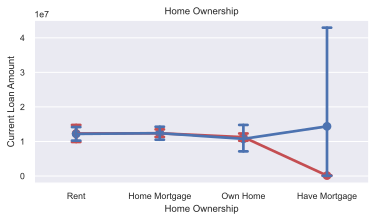

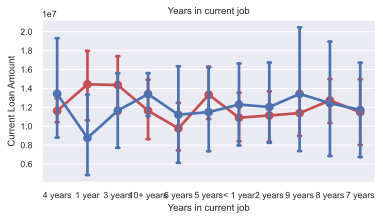

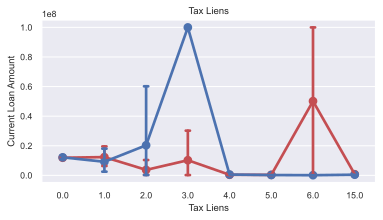

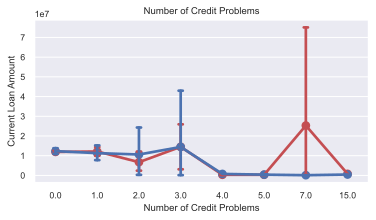

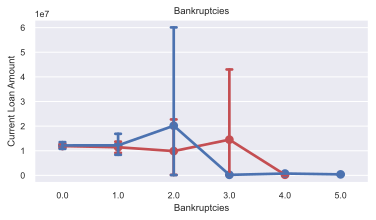

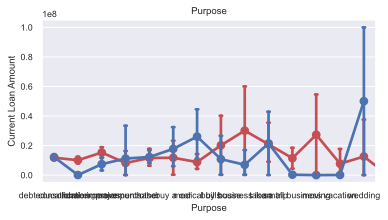

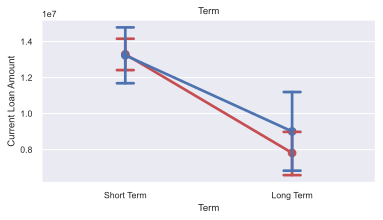

In [46]:
num_feature = 'Current Loan Amount'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='b')
    plt.title(col) 
    plt.show()

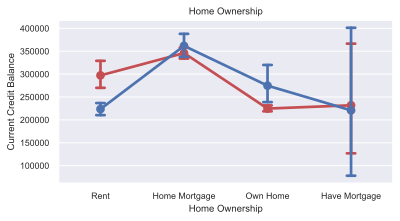

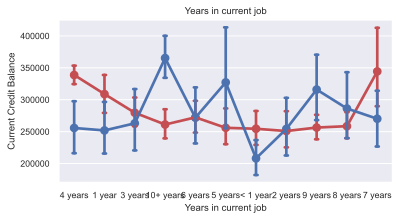

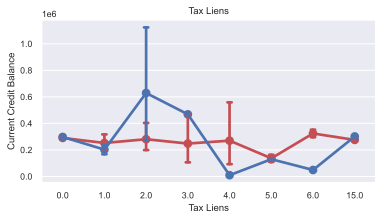

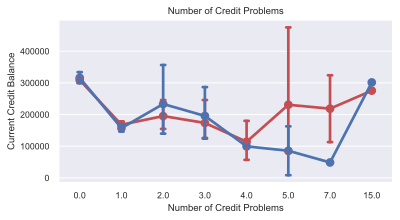

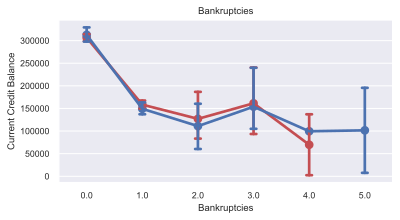

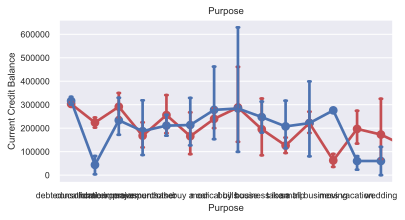

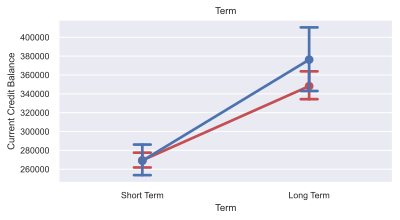

In [47]:
num_feature = 'Current Credit Balance'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='b')
    plt.title(col) 
    plt.show()

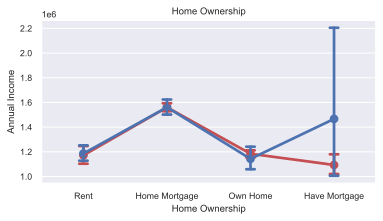

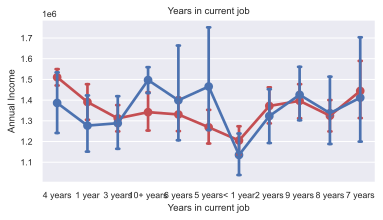

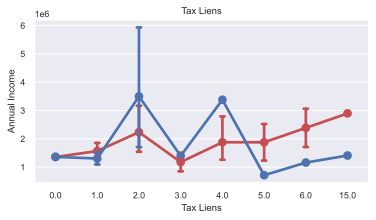

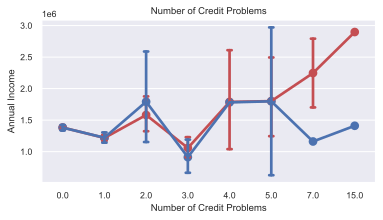

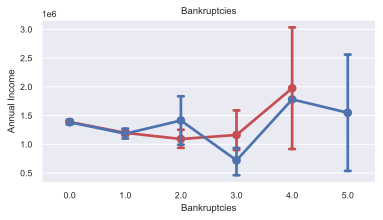

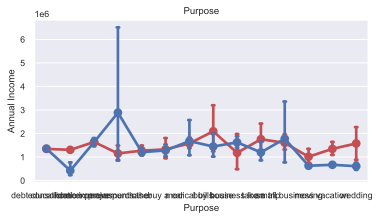

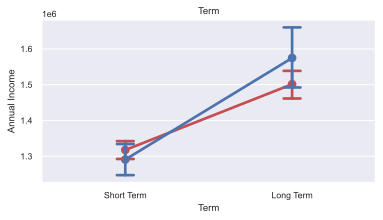

In [48]:
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='b')
    plt.title(col) 
    plt.show()

In [49]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()

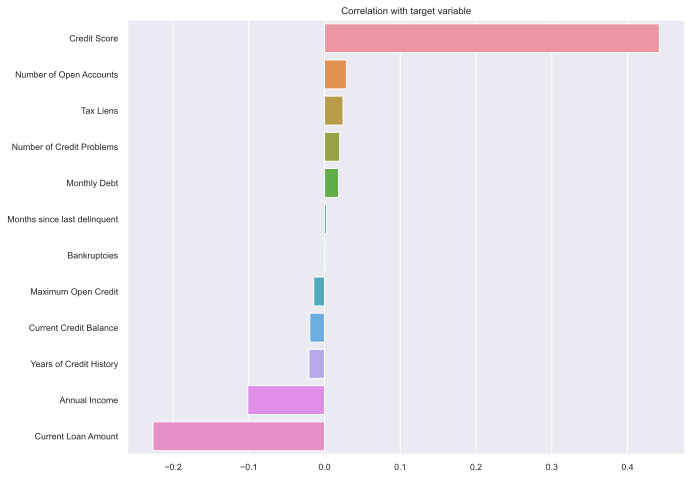

In [50]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [51]:
train_df

Home Ownership  Annual Income Years in current job  Tax Liens  \
0          Own Home       482087.0                  NaN        0.0   
1          Own Home      1025487.0            10+ years        0.0   
2     Home Mortgage       751412.0              8 years        0.0   
3          Own Home       805068.0              6 years        0.0   
4              Rent       776264.0              8 years        0.0   
...             ...            ...                  ...        ...   
7495           Rent       402192.0             < 1 year        0.0   
7496  Home Mortgage      1533984.0               1 year        0.0   
7497           Rent      1878910.0              6 years        0.0   
7498  Home Mortgage            NaN                  NaN        0.0   
7499           Rent            NaN              4 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                        11.0                     26.3             685960.0   
1                        15.0                     15.3            1181730.0   
2                        11.0                     35.0            1182434.0   
3                         8.0                     22.5             147400.0   
4                        13.0                     13.6             385836.0   
...                       ...                      ...                  ...   
7495                      3.0                      8.5             107866.0   
7496                     10.0                     26.5             686312.0   
7497                     12.0                     32.1            1778920.0   
7498                     21.0                     26.5            1141250.0   
7499                      8.0                      9.4             480832.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                           1.0                           NaN           1.0   
1                           0.0                           NaN           0.0   
2                           0.0                           NaN           0.0   
3                           1.0                           NaN           1.0   
4                           1.0                           NaN           0.0   
...                         ...                           ...           ...   
7495                        0.0                           NaN           0.0   
7496                        0.0                          43.0           0.0   
7497                        0.0                           NaN           0.0   
7498                        0.0                           NaN           0.0   
7499                        0.0                           NaN           0.0   

                 Purpose        Term  Current Loan Amount  \
0     debt consolidation  Short Term           99999999.0   
1     debt consolidation   Long Term             264968.0   
2     debt consolidation  Short Term           99999999.0   
3     debt consolidation  Short Term             121396.0   
4     debt consolidation  Short Term             125840.0   
...                  ...         ...                  ...   
7495               other  Short Term             129360.0   
7496  debt consolidation   Long Term             444048.0   
7497           buy a car  Short Term           99999999.0   
7498  debt consolidation  Short Term             615274.0   
7499  debt consolidation  Short Term              26928.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                    47386.0        7914.0         749.0               0  
1                   394972.0       18373.0         737.0               1  
2                   308389.0       13651.0         742.0               0  
3                    95855.0       11338.0         694.0               0  
4                    93309.0        7180.0         719.0               0  
...                      ...           ...           ...             ...  
7495    

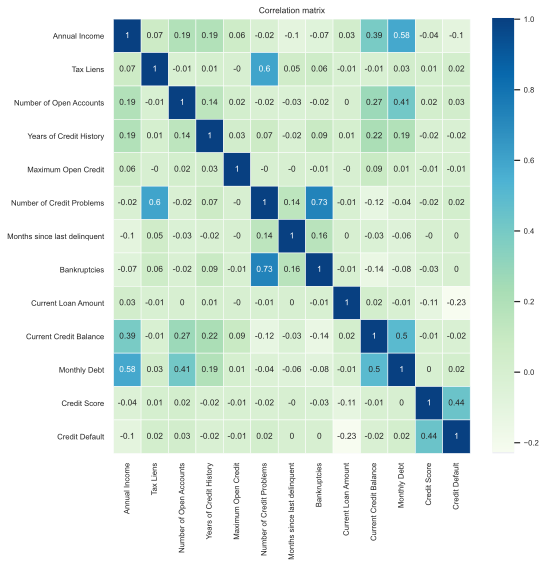

In [52]:
plt.figure(figsize = (8,8))
sns.set(font_scale=0.7)
corr_matrix = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr()
corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

In [53]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 22)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(9,5))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [54]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 19):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (9, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

## 3. Обрабртка выбросов

## 4. Заполнение пропусков и баллансировка классов

In [55]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [56]:
class DataNaN():
    """Заполнение пропусков"""
    
    def __init__(self):
        self.num_feature_names = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
                                  'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount',
                                  'Current Credit Balance', 'Monthly Debt', 'Credit Score']
        self.cat_feature_names = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems',
                                  'Bankruptcies', 'Purpose', 'Term'
                                 ]
        self.feature_names = self.num_feature_names + self.cat_feature_names
        
        self.target_name = 'Annual Income'
        
    def nan_features(self, X):
        for col in self.cat_feature_names:
            if X[col].isna().sum() > 0:
                X[col + '_nan'] = 0
                X.loc[X[col].isna(), (col + '_nan')] = 1
                a = self.cat_stats[col].iloc[0]
                X.loc[X[col + '_nan'] == 1, col] = a
        for col in self.num_feature_names:
            if X[col].isna().sum() > 0:
                X[col + '_nan'] = 0
                X.loc[X[col].isna(), (col + '_nan')] = 1
                X.loc[X[col + '_nan'] == 1, col] = self.dict_med.get(col)
                
    def med_num_features(self, X):
        self.num_stats = []
        for col in self.num_feature_names:
            med = X[col].median()
            self.num_stats.append(med)
        self.dict_med = {self.num_feature_names[i]: self.num_stats[i] for i in range(len(self.num_feature_names))}
        
    def mode_cat_features(self, X):
        self.cat_stats = X.mode()
        self.cat_stats = pd.DataFrame(self.cat_stats)
        
    def annual_income_nan(self, X, target_df):
        X_copy = X.copy()
        
        
        
        test_df = X_copy.loc[X_copy['Annual Income'].isna()]
        X_copy = X_copy.drop(X_copy.loc[X_copy['AnnualIncome'].isna()])
        X_copy = X_copy.drop(columns=['Annual Income', 'Years in current job', 'Months since last delinquent',
                                       'Bankruptcies', 'Credit Score', 'Credit Default'])
        
        target_df = target_df.copy().drop(columns=['Annual Income', 'Years in current job', 'Months since last delinquent',
                                       'Bankruptcies', 'Credit Score', 'Credit Default'])
        y_train = X_copy['Annual Income']
        y_test = test_df['Annual Income']
        y_target = target_df['Annual Income'].copy()
        
        frozen_params = {
        'class_weights':[0.5, disbalance], 
        'silent':True,
        'random_state':21,
         'cat_features':self.cat_feature_names,
         'eval_metric':'F1',
         'early_stopping_rounds':30
         }
                
        self.catb = catb.CatBoostRegressor(**frozen_params, iterations=400, max_depth=3, #ignored_features=CAT_FEATURE_NAMES, 
                                    one_hot_max_size=10, subsample=1, reg_lambda=0.9, min_data_in_leaf=7)

        self.catb.fit(X_train_br, y_train_br, plot=True, 
                     eval_set=(X_train_br, y_train_br))

        evaluate_preds(catb, X_copy, test_df, y_train, y_test)
        
    def preproc_annual_income(self, X):
        X = pd.get_dummies(X, columns=self.cat_feature_names)
        self.X_trans_test = X.loc[X['Annual Income_nan'] == 1].drop(columns=self.target_name)
        self.X_trans_train = X.loc[X['Annual Income_nan'] == 0].drop(columns=self.target_name)
        self.y_trans_train = X.loc[X['Annual Income_nan'] == 0, self.target_name]
        
        self.X_train_br, self.X_valid_br, self.y_train_br, self.y_valid_br = train_test_split(self.X_trans_train,
                                                                                              self.y_trans_train, 
                                                                                              test_size=0.3,
                                                                                              shuffle=True,
                                                                                              random_state=21)
    
    def fit_annual_income(self):
        frozen_params = {
        #'class_weights':[0.5, disbalance], 
        'silent':True,
        'random_state':21,
         #'cat_features':self.cat_feature_names,
         'eval_metric':'F1',
         'early_stopping_rounds':30
         }
                
        self.catb = catb.CatBoostRegressor(**frozen_params, iterations=400, max_depth=3, ignored_features=self.cat_feature_names, 
                                    one_hot_max_size=2, subsample=1, reg_lambda=0.9, min_data_in_leaf=7)

        self.catb.fit(self.X_train_br, self.y_train_br, plot=True, 
                     eval_set=(self.X_train_br, self.y_train_br))
        
    def predict_annual_income(self, X):
        self.X_trans_test = X.loc[X['Annual Income_nan'] == 1].drop(columns=self.target_name)
        self.X_train_br, self.X_valid_br, self.y_train_br, self.y_valid_br = train_test_split(self.X_trans_train,
                                                                                              self.y_trans_train, 
                                                                                              test_size=0.3,
                                                                                              shuffle=True,
                                                                                              random_state=21)
        y_train_preds = self.catb.predict(self.X_train_br)
        y_test_preds = self.catb.predict(self.X_valid_br)
        
        print("Train R2:\t" + str(round(r2(self.y_train_br, y_train_preds), 4)))
        print("Test R2:\t" + str(round(r2(self.y_valid_br, y_test_preds), 4)))
        
        predictions = self.catb.predict(self.X_trans_test)
        
        X.loc[X['Annual Income_nan'] == 1, 'Annual Income'] = predictions
        
        return X

In [57]:
datanan = DataNaN()
datanan.med_num_features(train_df)
datanan.mode_cat_features(train_df)
datanan.nan_features(train_df)
datanan.nan_features(test_df)
#datanan.preproc_annual_income(train_df)
#datanan.preproc_annual_income(test_df)
#datanan.fit_annual_income()
#datanan.predict_annual_income(train_df)
#datanan.predict_annual_income(test_df)

train_df.isna().sum()

Home Ownership                      0
Annual Income                       0
Years in current job                0
Tax Liens                           0
Number of Open Accounts             0
Years of Credit History             0
Maximum Open Credit                 0
Number of Credit Problems           0
Months since last delinquent        0
Bankruptcies                        0
Purpose                             0
Term                                0
Current Loan Amount                 0
Current Credit Balance              0
Monthly Debt                        0
Credit Score                        0
Credit Default                      0
Years in current job_nan            0
Bankruptcies_nan                    0
Annual Income_nan                   0
Months since last delinquent_nan    0
Credit Score_nan                    0
dtype: int64

In [58]:
modes = train_df[CAT_FEATURE_NAMES].mode()
train_df[CAT_FEATURE_NAMES] = train_df[CAT_FEATURE_NAMES].fillna(modes)
train_df.isna().sum()

Home Ownership                      0
Annual Income                       0
Years in current job                0
Tax Liens                           0
Number of Open Accounts             0
Years of Credit History             0
Maximum Open Credit                 0
Number of Credit Problems           0
Months since last delinquent        0
Bankruptcies                        0
Purpose                             0
Term                                0
Current Loan Amount                 0
Current Credit Balance              0
Monthly Debt                        0
Credit Score                        0
Credit Default                      0
Years in current job_nan            0
Bankruptcies_nan                    0
Annual Income_nan                   0
Months since last delinquent_nan    0
Credit Score_nan                    0
dtype: int64

In [59]:
train_df.loc[train_df['Years in current job_nan'] == 1]

Home Ownership  Annual Income Years in current job  Tax Liens  \
0          Own Home       482087.0            10+ years        0.0   
22             Rent       463790.0            10+ years        0.0   
24         Own Home      1168386.0            10+ years        0.0   
58    Home Mortgage       992845.0            10+ years        0.0   
60    Home Mortgage      1630029.0            10+ years        0.0   
...             ...            ...                  ...        ...   
7368           Rent       408709.0            10+ years        0.0   
7409  Home Mortgage      1939349.0            10+ years        0.0   
7413           Rent      1784537.0            10+ years        0.0   
7439  Home Mortgage       671270.0            10+ years        0.0   
7498  Home Mortgage      1168386.0            10+ years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                        11.0                     26.3             685960.0   
22                        6.0                     28.3             288442.0   
24                       12.0                     25.0            1216336.0   
58                       17.0                     21.2            1132054.0   
60                       10.0                     17.3             697114.0   
...                       ...                      ...                  ...   
7368                     13.0                     14.0             403106.0   
7409                     10.0                     17.5             322652.0   
7413                     11.0                     20.1             269676.0   
7439                     12.0                     20.6             263406.0   
7498                     21.0                     26.5            1141250.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                           1.0                          32.0           1.0   
22                          0.0                          32.0           0.0   
24                          0.0                          61.0           0.0   
58                          0.0                          32.0           0.0   
60                          0.0                          32.0           0.0   
...                         ...                           ...           ...   
7368                        1.0                          32.0           1.0   
7409                        0.0                          61.0           0.0   
7413                        0.0                          13.0           0.0   
7439                        0.0                          32.0           0.0   
7498                        0.0                          32.0           0.0   

      ... Current Loan Amount Current Credit Balance  Monthly Debt  \
0     ...          99999999.0                47386.0        7914.0   
22    ...          99999999.0               157700.0        5063.0   
24    ...            467676.0               818311.0       37530.0   
58    ...            207812.0               294291.0       25483.0   
60    ...            230362.0               260680.0        6181.0   
...   ...                 ...                    ...           ...   
7368  ...            111892.0               143773.0        3242.0   
7409  ...            126720.0                56563.0       22949.0   
7413  ...            449196.0               204250.0       22307.0   
7439  ...          99999999.0               151278.0        6937.0   
7498  ...            615274.0               476064.0       37118.0   

      Credit Score  Credit Default  Years in current job_nan  \
0            749.0               0                         1   
22           738.0               0                         1   
24           731.0               0                         1   
58           739.0               0                         1   
60           714.0               0                         1   
...            ...             ...       

In [60]:
train_df.loc[train_df['Maximum Open Credit'] == 0]

Home Ownership  Annual Income Years in current job  Tax Liens  \
8     Home Mortgage      1168386.0              5 years        0.0   
91             Rent       601369.0            10+ years        0.0   
196            Rent       815157.0              7 years        0.0   
294   Home Mortgage      2033931.0              7 years        0.0   
309            Rent      1245792.0              3 years        0.0   
...             ...            ...                  ...        ...   
6593  Home Mortgage      1168386.0              8 years        0.0   
6851  Home Mortgage      2251728.0            10+ years        0.0   
7014  Home Mortgage      1223771.0              5 years        0.0   
7124           Rent      1168386.0               1 year        0.0   
7233  Home Mortgage      2405932.0            10+ years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
8                        17.0                     15.7                  0.0   
91                        6.0                     16.9                  0.0   
196                       3.0                      8.8                  0.0   
294                       6.0                     21.1                  0.0   
309                       5.0                     22.4                  0.0   
...                       ...                      ...                  ...   
6593                     10.0                     13.0                  0.0   
6851                      8.0                     15.4                  0.0   
7014                      9.0                     24.0                  0.0   
7124                      4.0                     11.0                  0.0   
7233                      8.0                     24.5                  0.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
8                           1.0                          32.0           1.0   
91                          0.0                          14.0           0.0   
196                         0.0                          32.0           0.0   
294                         0.0                          32.0           0.0   
309                         0.0                          58.0           0.0   
...                         ...                           ...           ...   
6593                        0.0                          32.0           0.0   
6851                        0.0                          32.0           0.0   
7014                        0.0                          32.0           0.0   
7124                        0.0                          50.0           0.0   
7233                        0.0                          32.0           0.0   

      ... Current Loan Amount Current Credit Balance  Monthly Debt  \
8     ...            129734.0                   19.0          17.0   
91    ...            165924.0                    0.0        9021.0   
196   ...            218042.0                    0.0        5855.0   
294   ...            108042.0                    0.0       30340.0   
309   ...            338096.0                    0.0         395.0   
...   ...                 ...                    ...           ...   
6593  ...            672078.0                   19.0        8860.0   
6851  ...            760452.0                    0.0       36778.0   
7014  ...            751454.0                    0.0       15348.0   
7124  ...            134024.0                    0.0           0.0   
7233  ...            270468.0                75392.0        5493.0   

      Credit Score  Credit Default  Years in current job_nan  \
8            731.0               0                         0   
91           738.0               0                         0   
196          738.0               0                         0   
294          742.0               0                         0   
309          659.0               0                         0   
...            ...             ...       

In [61]:
train_df.loc[train_df['Monthly Debt'] == 0]

Home Ownership  Annual Income Years in current job  Tax Liens  \
780   Home Mortgage       867749.0            10+ years        0.0   
1643           Rent      1168386.0              9 years        0.0   
3219  Home Mortgage      1168386.0            10+ years        0.0   
3496           Rent       233567.0               1 year        0.0   
4165           Rent      1254513.0            10+ years        0.0   
7124           Rent      1168386.0               1 year        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
780                       2.0                     16.5                  0.0   
1643                      3.0                     10.0                  0.0   
3219                      3.0                     18.5                  0.0   
3496                      7.0                     11.7                  0.0   
4165                      6.0                     23.4                  0.0   
7124                      4.0                     11.0                  0.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
780                         0.0                          66.0           0.0   
1643                        0.0                          32.0           0.0   
3219                        0.0                          32.0           0.0   
3496                        0.0                           0.0           0.0   
4165                        0.0                          60.0           0.0   
7124                        0.0                          50.0           0.0   

      ... Current Loan Amount Current Credit Balance  Monthly Debt  \
780   ...             75350.0                    0.0           0.0   
1643  ...            332156.0                    0.0           0.0   
3219  ...             79200.0                    0.0           0.0   
3496  ...            210166.0                    0.0           0.0   
4165  ...          99999999.0                    0.0           0.0   
7124  ...            134024.0                    0.0           0.0   

      Credit Score  Credit Default  Years in current job_nan  \
780          704.0               0                         0   
1643         731.0               1                         0   
3219         731.0               0                         0   
3496         746.0               0                         0   
4165         748.0               0                         0   
7124         731.0               0                         0   

      Bankruptcies_nan  Annual Income_nan  Months since last delinquent_nan  \
780                  0                  0                                 0   
1643                 0                  1                                 1   
3219                 0                  1                                 1   
3496                 1                  0                                 0   
4165                 0                  0                                 0   
7124                 0                  1                                 0   

      Credit Score_nan  
780                  0  
1643                 1  
3219                 1  
3496                 0  
4165                 0  
7124                 1  

[6 rows x 22 columns]

In [62]:
train_df['Bankruptcies'].mode()

0    0.0
dtype: float64

In [63]:
FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES
CAT_FEATURE_NAMES

['Home Ownership',
 'Years in current job',
 'Tax Liens',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term']

In [64]:
test_df.isna().sum()

Home Ownership                      0
Annual Income                       0
Years in current job                0
Tax Liens                           0
Number of Open Accounts             0
Years of Credit History             0
Maximum Open Credit                 0
Number of Credit Problems           0
Months since last delinquent        0
Bankruptcies                        0
Purpose                             0
Term                                0
Current Loan Amount                 0
Current Credit Balance              0
Monthly Debt                        0
Credit Score                        0
Years in current job_nan            0
Bankruptcies_nan                    0
Annual Income_nan                   0
Months since last delinquent_nan    0
Credit Score_nan                    0
dtype: int64

In [65]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [66]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_xgb = xgb.XGBClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21)
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

In [67]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [68]:
def run_experiment(X_train, X_test, y_train, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

## 5. Генерация новых признаков

очень маленький уровень значимости по критерию Манна-Уитни у признаков Months since last delinquent, Bankruptcies, поэтому скорей всего на них обучать модель в конечном варианте не буду. глядя на распределение целевой переменной, можно сделать вывод, что для некоторых признаков можно добавить категориальный признак: для Annual Income можно сделать разбивку на отметке около 8 720 000 (с запасом можно на 8 750 000); для Tax Liens разбить < 6 и >=6; для Years of Credit History разбить на отметке 52; для MaximumOpen Credit разбить на отметке 6 700 000; для Numbers of Credit Problem разбить на < 6 и >=6; для Current Loan Amount разбить на отметке 790 000; для Current Credit Ballance га отметке 4 000 000; для Credit Score на отметке в 760.

In [69]:
def new_feature(X):
    #Annual Income
    X['Annual Income_8 750 000'] = 0
    X.loc[X['Annual Income'] >= 8750000, 'Annual Income_8 750 000'] = 1
    
    #Tax Liens
    X['Tax Liens_6'] = 0
    X.loc[X['Tax Liens'] >= 6, 'Tax Liens_6'] = 1
    
    #Years of Credit History
    X['Years of Credit History_52'] = 0
    X.loc[X['Years of Credit History'] >= 52, 'Years of Credit History_52'] = 1
    
    #Maximum Open Credit
    X['Maximum Open Credit_6 700 000'] = 0
    X.loc[X['Maximum Open Credit'] >= 6700000, 'Maximum Open Credit_6 700 000'] = 1
    
    #Numbers of Credit Problem
    X['Number of Credit Problems_6'] = 0
    X.loc[X['Number of Credit Problems'] >= 6, 'Number of Credit Problems_6'] = 1
    
    #Current Loan Amount
    X['Current Loan Amount_790 000'] = 0
    X.loc[X['Current Loan Amount'] >= 790000, 'Current Loan Amount_790 000'] =1
    
    #Current Credit Balance
    X['Current Credit Balance_4 000 000'] = 0
    X.loc[X['Current Credit Balance'] >= 4000000, 'Current Credit Balance_4 000 000'] = 1
    
    #Credit Score
    X['Credit Score_760'] =0 
    X.loc[X['Credit Score'] >= 760, 'Credit Score_760'] = 1

In [70]:
def dummies_features(X, features):
    for i, df in enumerate(X):
        X[i] = pd.get_dummies(df, columns=features)


In [71]:
train_df['bankruptcies_cred_probl_sum'] = train_df['Bankruptcies'] + train_df['Number of Credit Problems']
test_df['bankruptcies_cred_probl_sum'] = test_df['Bankruptcies'] + test_df['Number of Credit Problems']
train_df['tax_liens_cred_probl_sum'] = train_df['Tax Liens'] + train_df['Number of Credit Problems']
test_df['tax_liens_cred_probl_sum'] = test_df['Tax Liens'] + test_df['Number of Credit Problems']
train_df['annual_incom_monthly_debt_ratio'] = train_df['Annual Income'] + train_df['Monthly Debt']
test_df['annual_incom_monthly_debt_ratio'] = test_df['Annual Income'] + test_df['Monthly Debt']
train_df['curr_cred_ball_mon_debt_sqrt'] = train_df['Current Credit Balance'] + train_df['Monthly Debt']
test_df['curr_cred_ball_mon_debt_sqrt'] = test_df['Current Credit Balance'] + test_df['Monthly Debt']
train_df['annual_incom_curr_cred_ball_ratio'] = train_df['Annual Income'] + train_df['Current Credit Balance']
test_df['annual_incom_curr_cred_ball_ratio'] = test_df['Annual Income'] + test_df['Current Credit Balance']

In [72]:
train_df.isna().sum()

Home Ownership                       0
Annual Income                        0
Years in current job                 0
Tax Liens                            0
Number of Open Accounts              0
Years of Credit History              0
Maximum Open Credit                  0
Number of Credit Problems            0
Months since last delinquent         0
Bankruptcies                         0
Purpose                              0
Term                                 0
Current Loan Amount                  0
Current Credit Balance               0
Monthly Debt                         0
Credit Score                         0
Credit Default                       0
Years in current job_nan             0
Bankruptcies_nan                     0
Annual Income_nan                    0
Months since last delinquent_nan     0
Credit Score_nan                     0
bankruptcies_cred_probl_sum          0
tax_liens_cred_probl_sum             0
annual_incom_monthly_debt_ratio      0
curr_cred_ball_mon_debt_s

## 6. Предобработка данных и отбор признаков

In [73]:
target_name = ['Credit Default']

In [74]:
X = train_df.drop(columns=target_name)
y = pd.Series(train_df['Credit Default'])
#y = train_df[target_name]
#y = pd.Series(y[target_name], index=False)
#y

In [75]:
#transformer = RobustScaler(quantile_range=(2.5, 97.5)).fit(X_train[NUM_FEATURE_NAMES])
transformer = AdjustedScaler().fit(X[NUM_FEATURE_NAMES])
#X_train_copy = X_train.copy()
#transformer.transform(X_train[NUM_FEATURE_NAMES])
#X_test_copy = X_test.copy()
transformer.transform(X[NUM_FEATURE_NAMES])
#test_df_copy = test_df.copy()
transformer.transform(test_df[NUM_FEATURE_NAMES])

new_feature(X)
#new_feature(X_test)
new_feature(test_df)

int_to_str(X)
#int_to_str(X_test)
int_to_str(test_df)

#X_train_copy.shape, X_test_copy.shape, test_df_copy.shape
X

Home Ownership  Annual Income Years in current job Tax Liens  \
0          Own Home       482087.0            10+ years       0.0   
1          Own Home      1025487.0            10+ years       0.0   
2     Home Mortgage       751412.0              8 years       0.0   
3          Own Home       805068.0              6 years       0.0   
4              Rent       776264.0              8 years       0.0   
...             ...            ...                  ...       ...   
7495           Rent       402192.0             < 1 year       0.0   
7496  Home Mortgage      1533984.0               1 year       0.0   
7497           Rent      1878910.0              6 years       0.0   
7498  Home Mortgage      1168386.0            10+ years       0.0   
7499           Rent      1168386.0              4 years       0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                        11.0                     26.3             685960.0   
1                        15.0                     15.3            1181730.0   
2                        11.0                     35.0            1182434.0   
3                         8.0                     22.5             147400.0   
4                        13.0                     13.6             385836.0   
...                       ...                      ...                  ...   
7495                      3.0                      8.5             107866.0   
7496                     10.0                     26.5             686312.0   
7497                     12.0                     32.1            1778920.0   
7498                     21.0                     26.5            1141250.0   
7499                      8.0                      9.4             480832.0   

     Number of Credit Problems  Months since last delinquent Bankruptcies  \
0                          1.0                          32.0          1.0   
1                          0.0                          32.0          0.0   
2                          0.0                          32.0          0.0   
3                          1.0                          32.0          1.0   
4                          1.0                          32.0          0.0   
...                        ...                           ...          ...   
7495                       0.0                          32.0          0.0   
7496                       0.0                          43.0          0.0   
7497                       0.0                          32.0          0.0   
7498                       0.0                          32.0          0.0   
7499                       0.0                          32.0          0.0   

      ... curr_cred_ball_mon_debt_sqrt annual_incom_curr_cred_ball_ratio  \
0     ...                      55300.0                          529473.0   
1     ...                     413345.0                         1420459.0   
2     ...                     322040.0                         1059801.0   
3     ...                     107193.0                          900923.0   
4     ...                     100489.0                          869573.0   
...   ...                          ...                               ...   
7495  ...                      75392.0                          475684.0   
7496  ...                     469182.0                         1990383.0   
7497  ...                     490291.0                         2356722.0   
7498  ...                     513182.0                         1644450.0   
7499  ...                     297253.0                         1456578.0   

      Annual Income_8 750 000  Tax Liens_6  Years of Credit History_52  \
0                           0            0                           0   
1                           0            0                           0   
2                           0            0                           0   
3                           0            0                           0   
4                  

In [76]:
X = pd.get_dummies(X, columns=CAT_FEATURE_NAMES)
#X_test = pd.concat([X_test, pd.get_dummies(X_test, columns=CAT_FEATURE_NAMES)], axis=1)
test_df = pd.get_dummies(test_df, columns=CAT_FEATURE_NAMES)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21, stratify=y)

In [78]:
dfs = [X_train, X_test, test_df, X]

In [79]:
X_train.columns

Index(['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Months since last delinquent',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Years in current job_nan', 'Bankruptcies_nan',
       'Annual Income_nan', 'Months since last delinquent_nan',
       'Credit Score_nan', 'bankruptcies_cred_probl_sum',
       'tax_liens_cred_probl_sum', 'annual_incom_monthly_debt_ratio',
       'curr_cred_ball_mon_debt_sqrt', 'annual_incom_curr_cred_ball_ratio',
       'Annual Income_8 750 000', 'Tax Liens_6', 'Years of Credit History_52',
       'Maximum Open Credit_6 700 000', 'Number of Credit Problems_6',
       'Current Loan Amount_790 000', 'Current Credit Balance_4 000 000',
       'Credit Score_760', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Years in current job_1 year',
       'Years in current job_10+ years'

In [80]:
for el in dfs:
    el.rename(columns={'Years in current job_< 1 year': 'Years in current job_less 1 year'}, inplace=True)

In [81]:
X

Annual Income  Number of Open Accounts  Years of Credit History  \
0          482087.0                     11.0                     26.3   
1         1025487.0                     15.0                     15.3   
2          751412.0                     11.0                     35.0   
3          805068.0                      8.0                     22.5   
4          776264.0                     13.0                     13.6   
...             ...                      ...                      ...   
7495       402192.0                      3.0                      8.5   
7496      1533984.0                     10.0                     26.5   
7497      1878910.0                     12.0                     32.1   
7498      1168386.0                     21.0                     26.5   
7499      1168386.0                      8.0                      9.4   

      Maximum Open Credit  Months since last delinquent  Current Loan Amount  \
0                685960.0                          32.0           99999999.0   
1               1181730.0                          32.0             264968.0   
2               1182434.0                          32.0           99999999.0   
3                147400.0                          32.0             121396.0   
4                385836.0                          32.0             125840.0   
...                   ...                           ...                  ...   
7495             107866.0                          32.0             129360.0   
7496             686312.0                          43.0             444048.0   
7497            1778920.0                          32.0           99999999.0   
7498            1141250.0                          32.0             615274.0   
7499             480832.0                          32.0              26928.0   

      Current Credit Balance  Monthly Debt  Credit Score  \
0                    47386.0        7914.0         749.0   
1                   394972.0       18373.0         737.0   
2                   308389.0       13651.0         742.0   
3                    95855.0       11338.0         694.0   
4                    93309.0        7180.0         719.0   
...                      ...           ...           ...   
7495                 73492.0        1900.0         697.0   
7496                456399.0       12783.0        7410.0   
7497                477812.0       12479.0         748.0   
7498                476064.0       37118.0         731.0   
7499                288192.0        9061.0         731.0   

      Years in current job_nan  ...  Purpose_medical bills  Purpose_moving  \
0                            1  ...                      0               0   
1                            0  ...                      0               0   
2                            0  ...                      0               0   
3                            0  ...                      0               0   
4                            0  ...                      0               0   
...                        ...  ...                    ...             ...   
7495                         0  ...                      0               0   
7496                         0  ...                      0               0   
7497                         0  ...                      0               0   
7498                         1  ...                      0               0   
7499                         0  ...                      0               0   

      Purpose_other  Purpose_renewable energy  Purpose_small business  \
0                 0                         0                       0   
1                 0                         0                       0   
2                 0                         0                       0   
3                 0                         0                       0   
4                 0                         0                       0   
...             ...                       ...                     ...   

#### Сбаллансируем классы

In [82]:
X_train.isna().sum()

Annual Income                   0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Months since last delinquent    0
                               ..
Purpose_take a trip             0
Purpose_vacation                0
Purpose_wedding                 0
Term_Long Term                  0
Term_Short Term                 0
Length: 80, dtype: int64

In [83]:
%%time
stata_not_balanced, models_not_balanced = run_experiment(X_train, X_test, y_train, y_test, method='not')
stata_not_balanced

[01:04:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7.4 s


f1_0_test_not  f1_0_train_not  f1_1_test_not  f1_1_train_not  \
0       0.854826        0.856941       0.329588        0.326356   
1       0.794283        0.855620       0.312590        0.527590   
2       0.783708        1.000000       0.465278        1.000000   
3       0.842015        0.973407       0.437690        0.925703   
4       0.848357        0.938660       0.424920        0.801973   
5       0.852843        0.918455       0.421053        0.716418   

   f1_macro_test_not  f1_macro_train_not model_name  
0           0.592207            0.591648         lr  
1           0.553437            0.691605        knn  
2           0.624493            1.000000       tree  
3           0.639853            0.949555        xgb  
4           0.636639            0.870316       lgbm  
5           0.636948            0.817436        cat

Undersampling

In [84]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
    
df_balanced[TARGET_NAME].value_counts()

1    1690
0    1690
Name: Credit Default, dtype: int64

In [85]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [86]:
%%time
stata_balanced_under, models_under = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='under')
stata_balanced_under

[01:04:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 4.63 s


f1_0_test_under  f1_0_train_under  f1_1_test_under  f1_1_train_under  \
0         0.673333          0.611469         0.510000          0.670131   
1         0.648501          0.741452         0.446352          0.748395   
2         0.701119          1.000000         0.500445          1.000000   
3         0.711828          0.993499         0.529825          0.993483   
4         0.714514          0.968658         0.520107          0.968620   
5         0.740935          0.915254         0.550593          0.913122   

   f1_macro_test_under  f1_macro_train_under model_name  
0             0.591667              0.640800         lr  
1             0.547427              0.744923        knn  
2             0.600782              1.000000       tree  
3             0.620826              0.993491        xgb  
4             0.617310              0.968639       lgbm  
5             0.645764              0.914188        cat

Oversampling

In [87]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    4310
1    3380
Name: Credit Default, dtype: int64

In [88]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [89]:
%%time
stata_balanced_over, models_over = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='over')
stata_balanced_over

[01:05:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7.95 s


f1_0_test_over  f1_0_train_over  f1_1_test_over  f1_1_train_over  \
0        0.791394         0.711106        0.482599         0.547003   
1        0.728863         0.786286        0.407643         0.717949   
2        0.771683         1.000000        0.438293         1.000000   
3        0.812165         0.976391        0.450262         0.969389   
4        0.820606         0.935284        0.495553         0.911470   
5        0.822949         0.921182        0.486346         0.890819   

   f1_macro_test_over  f1_macro_train_over model_name  
0            0.636996             0.629055         lr  
1            0.568253             0.752117        knn  
2            0.604988             1.000000       tree  
3            0.631213             0.972890        xgb  
4            0.658079             0.923377       lgbm  
5            0.654648             0.906001        cat

Tomek

In [90]:
tl = TomekLinks()
X_train_balanced, y_train_balanced = tl.fit_resample(X_train, y_train)

y_train_balanced.value_counts()

0    3688
1    1690
Name: Credit Default, dtype: int64

In [91]:
tl_1 = TomekLinks()
X_balanced, y_balanced = tl_1.fit_resample(X, y)

y_balanced.value_counts()

0    4625
1    2113
Name: Credit Default, dtype: int64

In [92]:
%%time
stata_balanced_tomek, models_tomek = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='tomek')
stata_balanced_tomek

[01:05:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 6 s


f1_0_test_tomek  f1_0_train_tomek  f1_1_test_tomek  f1_1_train_tomek  \
0         0.846914          0.835520         0.347368          0.367568   
1         0.768667          0.855263         0.381885          0.626498   
2         0.778255          1.000000         0.485050          1.000000   
3         0.824103          0.977034         0.465680          0.946323   
4         0.842151          0.945403         0.475504          0.858194   
5         0.849914          0.920015         0.476048          0.774583   

   f1_macro_test_tomek  f1_macro_train_tomek model_name  
0             0.597141              0.601544         lr  
1             0.575276              0.740881        knn  
2             0.631652              1.000000       tree  
3             0.644891              0.961679        xgb  
4             0.658828              0.901799       lgbm  
5             0.662981              0.847299        cat

SMOTE

In [93]:
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

y_train_balanced.value_counts()

1    4310
0    4310
Name: Credit Default, dtype: int64

In [94]:
%%time
stata_balanced_smote, models_smote = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='smote')
stata_balanced_smote

[01:05:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8.34 s


f1_0_test_smote  f1_0_train_smote  f1_1_test_smote  f1_1_train_smote  \
0         0.682687          0.621931         0.502994          0.676993   
1         0.682523          0.796930         0.424015          0.836596   
2         0.768356          1.000000         0.449944          1.000000   
3         0.843332          0.972483         0.468521          0.971102   
4         0.850900          0.934078         0.477477          0.925752   
5         0.851300          0.928360         0.465544          0.919106   

   f1_macro_test_smote  f1_macro_train_smote model_name  
0             0.592841              0.649462         lr  
1             0.553269              0.816763        knn  
2             0.609150              1.000000       tree  
3             0.655927              0.971793        xgb  
4             0.664189              0.929915       lgbm  
5             0.658422              0.923733        cat

In [95]:
stata_combined = stata_not_balanced.merge(stata_balanced_under, on='model_name') \
                                   .merge(stata_balanced_over, on='model_name') \
                                   .merge(stata_balanced_tomek, on='model_name') \
                                   .merge(stata_balanced_smote, on='model_name')
stata_combined.head()

f1_0_test_not  f1_0_train_not  f1_1_test_not  f1_1_train_not  \
0       0.854826        0.856941       0.329588        0.326356   
1       0.794283        0.855620       0.312590        0.527590   
2       0.783708        1.000000       0.465278        1.000000   
3       0.842015        0.973407       0.437690        0.925703   
4       0.848357        0.938660       0.424920        0.801973   

   f1_macro_test_not  f1_macro_train_not model_name  f1_0_test_under  \
0           0.592207            0.591648         lr         0.673333   
1           0.553437            0.691605        knn         0.648501   
2           0.624493            1.000000       tree         0.701119   
3           0.639853            0.949555        xgb         0.711828   
4           0.636639            0.870316       lgbm         0.714514   

   f1_0_train_under  f1_1_test_under  ...  f1_1_test_tomek  f1_1_train_tomek  \
0          0.611469         0.510000  ...         0.347368          0.367568   
1          0.741452         0.446352  ...         0.381885          0.626498   
2          1.000000         0.500445  ...         0.485050          1.000000   
3          0.993499         0.529825  ...         0.465680          0.946323   
4          0.968658         0.520107  ...         0.475504          0.858194   

   f1_macro_test_tomek  f1_macro_train_tomek  f1_0_test_smote  \
0             0.597141              0.601544         0.682687   
1             0.575276              0.740881         0.682523   
2             0.631652              1.000000         0.768356   
3             0.644891              0.961679         0.843332   
4             0.658828              0.901799         0.850900   

   f1_0_train_smote  f1_1_test_smote  f1_1_train_smote  f1_macro_test_smote  \
0          0.621931         0.502994          0.676993             0.592841   
1          0.796930         0.424015          0.836596             0.553269   
2          1.000000         0.449944          1.000000             0.609150   
3          0.972483         0.468521          0.971102             0.655927   
4          0.934078         0.477477          0.925752             0.664189   

   f1_macro_train_smote  
0              0.649462  
1              0.816763  
2              1.000000  
3              0.971793  
4              0.929915  

[5 rows x 31 columns]

In [96]:
stata_combined.describe()[
    ['f1_macro_test_not', 'f1_macro_test_under', 'f1_macro_test_over',
     'f1_macro_test_tomek', 'f1_macro_test_smote',
     'f1_1_test_not', 'f1_1_test_under', 'f1_1_test_over',
     'f1_1_test_tomek', 'f1_1_test_smote']
]

f1_macro_test_not  f1_macro_test_under  f1_macro_test_over  \
count           6.000000             6.000000            6.000000   
mean            0.613929             0.603963            0.625696   
std             0.034526             0.033369            0.033981   
min             0.553437             0.547427            0.568253   
25%             0.600278             0.593946            0.611544   
50%             0.630566             0.609046            0.634105   
75%             0.636870             0.619947            0.650235   
max             0.639853             0.645764            0.658079   

       f1_macro_test_tomek  f1_macro_test_smote  f1_1_test_not  \
count             6.000000             6.000000       6.000000   
mean              0.628462             0.622299       0.398520   
std               0.035224             0.044713       0.062179   
min               0.575276             0.553269       0.312590   
25%               0.605769             0.596918       0.352454   
50%               0.638272             0.632538       0.422986   
75%               0.655344             0.657798       0.434498   
max               0.662981             0.664189       0.465278   

       f1_1_test_under  f1_1_test_over  f1_1_test_tomek  f1_1_test_smote  
count         6.000000        6.000000         6.000000         6.000000  
mean          0.509554        0.460116         0.438589         0.464749  
std           0.035452        0.033988         0.058643         0.026525  
min           0.446352        0.407643         0.347368         0.424015  
25%           0.502834        0.441285         0.402834         0.453844  
50%           0.515054        0.466430         0.470592         0.467032  
75%           0.527395        0.485409         0.475912         0.475238  
max           0.550593        0.495553         0.485050         0.502994

In [97]:
stata_combined.sort_values('f1_1_test_over', ascending=False).iloc[0]

f1_0_test_not           0.848357
f1_0_train_not           0.93866
f1_1_test_not            0.42492
f1_1_train_not          0.801973
f1_macro_test_not       0.636639
f1_macro_train_not      0.870316
model_name                  lgbm
f1_0_test_under         0.714514
f1_0_train_under        0.968658
f1_1_test_under         0.520107
f1_1_train_under         0.96862
f1_macro_test_under      0.61731
f1_macro_train_under    0.968639
f1_0_test_over          0.820606
f1_0_train_over         0.935284
f1_1_test_over          0.495553
f1_1_train_over          0.91147
f1_macro_test_over      0.658079
f1_macro_train_over     0.923377
f1_0_test_tomek         0.842151
f1_0_train_tomek        0.945403
f1_1_test_tomek         0.475504
f1_1_train_tomek        0.858194
f1_macro_test_tomek     0.658828
f1_macro_train_tomek    0.901799
f1_0_test_smote           0.8509
f1_0_train_smote        0.934078
f1_1_test_smote         0.477477
f1_1_train_smote        0.925752
f1_macro_test_smote     0.664189
f1_macro_t

In [98]:
X_train_balanced, y_train_balanced = tl.fit_resample(X_train, y_train)

y_train_balanced.value_counts()

0    3688
1    1690
Name: Credit Default, dtype: int64

In [99]:
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_balanced, y_train_balanced)

y_train_balanced.value_counts()

1    3688
0    3688
Name: Credit Default, dtype: int64

In [100]:
%%time
stata_balanced_smote, models_smote = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='smote')
stata_balanced_smote

[01:05:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7.42 s


f1_0_test_smote  f1_0_train_smote  f1_1_test_smote  f1_1_train_smote  \
0         0.662921          0.630001         0.508197          0.694393   
1         0.662040          0.830996         0.438332          0.856462   
2         0.771142          1.000000         0.471885          1.000000   
3         0.814815          0.978615         0.453228          0.977992   
4         0.834437          0.940994         0.489796          0.935080   
5         0.839223          0.931436         0.505435          0.924523   

   f1_macro_test_smote  f1_macro_train_smote model_name  
0             0.585559              0.662197         lr  
1             0.550186              0.843729        knn  
2             0.621514              1.000000       tree  
3             0.634021              0.978304        xgb  
4             0.662117              0.938037       lgbm  
5             0.672329              0.927979        cat

In [101]:
model = models_over['cat']

In [102]:
pred_train = model.predict(X_train_balanced)
pred_test = model.predict(X_test)

evaluate_preds(model, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.96      0.83      3688
           1       0.94      0.65      0.77      3688

    accuracy                           0.81      7376
   macro avg       0.84      0.81      0.80      7376
weighted avg       0.84      0.81      0.80      7376

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1077
           1       0.54      0.44      0.49       423

    accuracy                           0.74      1500
   macro avg       0.67      0.65      0.65      1500
weighted avg       0.72      0.74      0.73      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               918  159
1               236  187


In [103]:
train_df.isna().sum()

Home Ownership                       0
Annual Income                        0
Years in current job                 0
Tax Liens                            0
Number of Open Accounts              0
Years of Credit History              0
Maximum Open Credit                  0
Number of Credit Problems            0
Months since last delinquent         0
Bankruptcies                         0
Purpose                              0
Term                                 0
Current Loan Amount                  0
Current Credit Balance               0
Monthly Debt                         0
Credit Score                         0
Credit Default                       0
Years in current job_nan             0
Bankruptcies_nan                     0
Annual Income_nan                    0
Months since last delinquent_nan     0
Credit Score_nan                     0
bankruptcies_cred_probl_sum          0
tax_liens_cred_probl_sum             0
annual_incom_monthly_debt_ratio      0
curr_cred_ball_mon_debt_s

In [104]:
X_train.isna().sum()

Annual Income                   0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Months since last delinquent    0
                               ..
Purpose_take a trip             0
Purpose_vacation                0
Purpose_wedding                 0
Term_Long Term                  0
Term_Short Term                 0
Length: 80, dtype: int64

In [105]:
X_train

Annual Income  Number of Open Accounts  Years of Credit History  \
5849       860301.0                      8.0                     15.9   
3814      1254513.0                      5.0                     10.5   
4458       763268.0                      9.0                     25.1   
5473       729505.0                     18.0                     18.4   
4832       462707.0                      6.0                     11.5   
...             ...                      ...                      ...   
1946       657286.0                      6.0                      8.4   
172       1197323.0                     17.0                     12.0   
327       1465337.0                      9.0                     17.7   
4459      1405164.0                     14.0                     11.8   
1025      8923844.0                     15.0                     17.2   

      Maximum Open Credit  Months since last delinquent  Current Loan Amount  \
5849             686092.0                          28.0             270622.0   
3814             122804.0                          36.0             193864.0   
4458             422774.0                          32.0              76384.0   
5473             582494.0                          58.0             372328.0   
4832             200926.0                          32.0           99999999.0   
...                   ...                           ...                  ...   
1946             100056.0                          32.0             208758.0   
172              671176.0                          32.0             290686.0   
327              125642.0                          32.0           99999999.0   
4459             356598.0                          32.0             445764.0   
1025            1452000.0                          32.0             670428.0   

      Current Credit Balance  Monthly Debt  Credit Score  \
5849                292125.0        6710.0         740.0   
3814                 31920.0        1965.0         716.0   
4458                345040.0       12021.0         701.0   
5473                258571.0       11064.0         680.0   
4832                145597.0        6594.0         736.0   
...                      ...           ...           ...   
1946                 66614.0        8764.0         740.0   
172                 213902.0       17660.0         748.0   
327                  62168.0       21248.0         747.0   
4459                292258.0       27050.0         699.0   
1025               1084710.0       62095.0         723.0   

      Years in current job_nan  ...  Purpose_medical bills  Purpose_moving  \
5849                         0  ...                      0               0   
3814                         0  ...                      0               0   
4458                         0  ...                      0               0   
5473                         0  ...                      0               0   
4832                         0  ...                      0               0   
...                        ...  ...                    ...             ...   
1946                         0  ...                      0               0   
172                          0  ...                      0               0   
327                          0  ...                      0               0   
4459                         0  ...                      0               0   
1025                         0  ...                      0               0   

      Purpose_other  Purpose_renewable energy  Purpose_small business  \
5849              0                         0                       0   
3814              0                         0                       0   
4458              0                         0                       0   
5473              0                         0                       0   
4832              0                         0                       0   
...             ...                       ...                     ...   

In [106]:
CAT_FEATURE_NAMES

['Home Ownership',
 'Years in current job',
 'Tax Liens',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term']

In [107]:
col_name = ["', '".join(X_train.columns)]
col_name
#len(col_name)

["Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Years in current job_nan', 'Bankruptcies_nan', 'Annual Income_nan', 'Months since last delinquent_nan', 'Credit Score_nan', 'bankruptcies_cred_probl_sum', 'tax_liens_cred_probl_sum', 'annual_incom_monthly_debt_ratio', 'curr_cred_ball_mon_debt_sqrt', 'annual_incom_curr_cred_ball_ratio', 'Annual Income_8 750 000', 'Tax Liens_6', 'Years of Credit History_52', 'Maximum Open Credit_6 700 000', 'Number of Credit Problems_6', 'Current Loan Amount_790 000', 'Current Credit Balance_4 000 000', 'Credit Score_760', 'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage', 'Home Ownership_Own Home', 'Home Ownership_Rent', 'Years in current job_1 year', 'Years in current job_10+ years', 'Years in current job_2 years', 'Years in current job_3 years', 'Years in current job_4 years', 'Years

In [108]:
col_name = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Years in current job_nan', 'Bankruptcies_nan', 'Annual Income_nan', 'Months since last delinquent_nan', 'Credit Score_nan', 'bankruptcies_cred_probl_sum', 'tax_liens_cred_probl_sum', 'annual_incom_monthly_debt_ratio', 'curr_cred_ball_mon_debt_sqrt', 'annual_incom_curr_cred_ball_ratio', 'Annual Income_8 750 000', 'Tax Liens_6', 'Years of Credit History_52', 'Maximum Open Credit_6 700 000', 'Number of Credit Problems_6', 'Current Loan Amount_790 000', 'Current Credit Balance_4 000 000', 'Credit Score_760', 'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage', 'Home Ownership_Own Home', 'Home Ownership_Rent', 'Years in current job_1 year', 'Years in current job_10+ years', 'Years in current job_2 years', 'Years in current job_3 years', 'Years in current job_4 years', 'Years in current job_5 years', 'Years in current job_6 years', 'Years in current job_7 years', 'Years in current job_8 years', 'Years in current job_9 years', 'Years in current job_less 1 year', 'Tax Liens_0.0', 'Tax Liens_1.0', 'Tax Liens_2.0', 'Tax Liens_3.0', 'Tax Liens_4.0', 'Tax Liens_5.0', 'Tax Liens_6.0', 'Tax Liens_7.0', 'Number of Credit Problems_0.0', 'Number of Credit Problems_1.0', 'Number of Credit Problems_2.0', 'Number of Credit Problems_3.0', 'Number of Credit Problems_4.0', 'Number of Credit Problems_5.0', 'Number of Credit Problems_6.0', 'Number of Credit Problems_7.0', 'Bankruptcies_0.0', 'Bankruptcies_1.0', 'Bankruptcies_2.0', 'Bankruptcies_3.0', 'Bankruptcies_4.0', 'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation', 'Purpose_educational expenses', 'Purpose_home improvements', 'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving', 'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business', 'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding', 'Term_Long Term', 'Term_Short Term']
col_name
len(col_name)

80

In [109]:
X_train.shape, X_test.shape, test_df.shape

((6000, 80), (1500, 80), (2500, 80))

In [110]:
for el in ['Number of Credit Problems_15.0', 'Bankruptcies_5.0', 'Tax Liens_15.0']:
    X_train[el] = 0
    X_test[el] = 0
for el in ['Tax Liens_7.0', 'Number of Credit Problems_6.0', 'Purpose_renewable energy']:    
    test_df[el] = 0

In [111]:
col_name = col_name + ['Tax Liens_7.0', 'Number of Credit Problems_6.0', 'Purpose_renewable energy']
col_name = list(set(col_name))
len(col_name)

80

In [112]:
X_train_balanced = X_train_balanced[col_name]
X_test = X_test[col_name]
test_df = test_df[col_name]

In [113]:
X_train

Annual Income  Number of Open Accounts  Years of Credit History  \
5849       860301.0                      8.0                     15.9   
3814      1254513.0                      5.0                     10.5   
4458       763268.0                      9.0                     25.1   
5473       729505.0                     18.0                     18.4   
4832       462707.0                      6.0                     11.5   
...             ...                      ...                      ...   
1946       657286.0                      6.0                      8.4   
172       1197323.0                     17.0                     12.0   
327       1465337.0                      9.0                     17.7   
4459      1405164.0                     14.0                     11.8   
1025      8923844.0                     15.0                     17.2   

      Maximum Open Credit  Months since last delinquent  Current Loan Amount  \
5849             686092.0                          28.0             270622.0   
3814             122804.0                          36.0             193864.0   
4458             422774.0                          32.0              76384.0   
5473             582494.0                          58.0             372328.0   
4832             200926.0                          32.0           99999999.0   
...                   ...                           ...                  ...   
1946             100056.0                          32.0             208758.0   
172              671176.0                          32.0             290686.0   
327              125642.0                          32.0           99999999.0   
4459             356598.0                          32.0             445764.0   
1025            1452000.0                          32.0             670428.0   

      Current Credit Balance  Monthly Debt  Credit Score  \
5849                292125.0        6710.0         740.0   
3814                 31920.0        1965.0         716.0   
4458                345040.0       12021.0         701.0   
5473                258571.0       11064.0         680.0   
4832                145597.0        6594.0         736.0   
...                      ...           ...           ...   
1946                 66614.0        8764.0         740.0   
172                 213902.0       17660.0         748.0   
327                  62168.0       21248.0         747.0   
4459                292258.0       27050.0         699.0   
1025               1084710.0       62095.0         723.0   

      Years in current job_nan  ...  Purpose_renewable energy  \
5849                         0  ...                         0   
3814                         0  ...                         0   
4458                         0  ...                         0   
5473                         0  ...                         0   
4832                         0  ...                         0   
...                        ...  ...                       ...   
1946                         0  ...                         0   
172                          0  ...                         0   
327                          0  ...                         0   
4459                         0  ...                         0   
1025                         0  ...                         0   

      Purpose_small business  Purpose_take a trip  Purpose_vacation  \
5849                       0                    0                 0   
3814                       0                    0                 0   
4458                       0                    0                 0   
5473                       0                    0                 0   
4832                       0                    0                 0   
...                      ...                  ...               ...   
1946                       0                    0                 0   
172                        0                    0                 0   
327                        

In [114]:
test_df

Credit Score_nan  Years in current job_9 years  \
0                    1                             0   
1                    0                             0   
2                    0                             0   
3                    0                             0   
4                    0                             0   
...                ...                           ...   
2495                 0                             0   
2496                 1                             0   
2497                 0                             0   
2498                 0                             0   
2499                 0                             0   

      Number of Credit Problems_6.0  Bankruptcies_1.0  \
0                                 0                 0   
1                                 0                 0   
2                                 0                 0   
3                                 0                 0   
4                                 0                 0   
...                             ...               ...   
2495                              0                 1   
2496                              0                 0   
2497                              0                 0   
2498                              0                 0   
2499                              0                 0   

      Current Credit Balance_4 000 000  Number of Credit Problems_4.0  \
0                                    0                              0   
1                                    0                              0   
2                                    0                              0   
3                                    0                              0   
4                                    0                              0   
...                                ...                            ...   
2495                                 0                              0   
2496                                 0                              0   
2497                                 0                              0   
2498                                 0                              0   
2499                                 0                              0   

      Years in current job_8 years  Number of Credit Problems_5.0  \
0                                0                              0   
1                                0                              0   
2                                0                              0   
3                                0                              0   
4                                0                              0   
...                            ...                            ...   
2495                             0                              0   
2496                             0                              0   
2497                             0                              0   
2498                             0                              0   
2499                             0                              0   

      Purpose_major purchase  Purpose_business loan  ...  Monthly Debt  \
0                          0                      0  ...        6813.0   
1                          0                      0  ...        2318.0   
2                          0                      0  ...       18729.0   
3                          0                      0  ...       27559.0   
4                          0                      0  ...       42605.0   
...                      ...                    ...  ...           ...   
2495                       0                      0  ...       15046.0   
2496                       0                      0  ...       32996.0   
2497                       0                      0  ...       36912.0   
2498                       0                      0  ...       13506.0   
2499                       0                      0  ...       23440.0   

      Number of Credit Problems_6  Bankruptcies_4.0  

## 7. Построение модели

In [115]:
X_train.isna().sum()

Annual Income                     0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Months since last delinquent      0
                                 ..
Term_Long Term                    0
Term_Short Term                   0
Number of Credit Problems_15.0    0
Bankruptcies_5.0                  0
Tax Liens_15.0                    0
Length: 83, dtype: int64

In [116]:
%%time
model_svc = SVC(C=0.05,
                kernel='poly'
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.19      0.32      3688
           1       0.55      1.00      0.71      3688

    accuracy                           0.59      7376
   macro avg       0.78      0.59      0.51      7376
weighted avg       0.78      0.59      0.51      7376

TEST

              precision    recall  f1-score   support

           0       1.00      0.17      0.29      1077
           1       0.32      1.00      0.49       423

    accuracy                           0.40      1500
   macro avg       0.66      0.58      0.39      1500
weighted avg       0.81      0.40      0.34      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               180  897
1                 0  423
Wall time: 5.03 s


In [117]:
float(y_train.value_counts()[0]) / float(y_train.value_counts()[1])

2.5502958579881656

In [118]:
disbalance = float(y_train_balanced.value_counts()[0]) / float(y_train_balanced.value_counts()[1])
disbalance

1.0

In [119]:
frozen_params = {
     'class_weights':[0.5, disbalance], 
     'silent':True,
     'random_state':21,
     #'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':30
}

In [120]:
ignored_features = []

In [121]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=400, max_depth=5, #ignored_features=CAT_FEATURE_NAMES, 
                                    one_hot_max_size=10, subsample=0.75, reg_lambda=0.7, min_data_in_leaf=3)
model_catb.fit(X_train_balanced, y_train_balanced, plot=True, eval_set=(X_train_balanced, y_train_balanced))

evaluate_preds(model_catb, X_train_balanced, X_test, y_train_balanced, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      3688
           1       0.77      0.93      0.84      3688

    accuracy                           0.83      7376
   macro avg       0.84      0.83      0.83      7376
weighted avg       0.84      0.83      0.83      7376

TEST

              precision    recall  f1-score   support

           0       0.85      0.62      0.71      1077
           1       0.42      0.72      0.53       423

    accuracy                           0.65      1500
   macro avg       0.64      0.67      0.62      1500
weighted avg       0.73      0.65      0.66      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               663  414
1               118  305
Wall time: 1.85 s


In [122]:
 %%time

model_catb_2 = catb.CatBoostClassifier(**frozen_params, iterations=500, max_depth=3, #ignored_features=CAT_FEATURE_NAMES, 
                                    one_hot_max_size=2, subsample=0.75, reg_lambda=0.9, min_data_in_leaf=3)
model_catb_2.fit(X_train_balanced, y_train_balanced, plot=True, eval_set=(X_train_balanced, y_train_balanced))

evaluate_preds(model_catb_2, X_train_balanced, X_test, y_train_balanced, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.64      0.74      3688
           1       0.72      0.92      0.81      3688

    accuracy                           0.78      7376
   macro avg       0.80      0.78      0.77      7376
weighted avg       0.80      0.78      0.77      7376

TEST

              precision    recall  f1-score   support

           0       0.85      0.58      0.69      1077
           1       0.41      0.74      0.53       423

    accuracy                           0.63      1500
   macro avg       0.63      0.66      0.61      1500
weighted avg       0.73      0.63      0.65      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               629  448
1               108  315
Wall time: 1.75 s


In [123]:
np.linspace(.1, 1.0, 15)

array([0.1       , 0.16428571, 0.22857143, 0.29285714, 0.35714286,
       0.42142857, 0.48571429, 0.55      , 0.61428571, 0.67857143,
       0.74285714, 0.80714286, 0.87142857, 0.93571429, 1.        ])

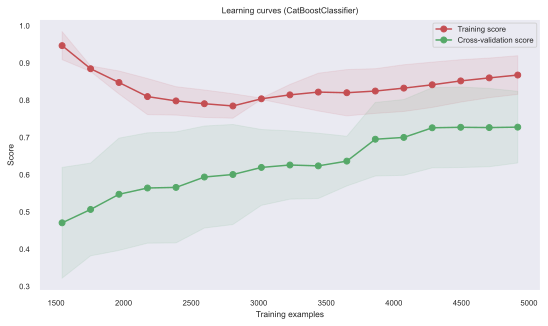

In [124]:
show_learning_curve_plot(model_catb, X_train_balanced, y_train_balanced)

In [125]:
y_test_pred_probs = model_catb.predict_proba(X_test)
y_test_pred_probs

array([[0.84985141, 0.15014859],
       [0.99053533, 0.00946467],
       [0.4877496 , 0.5122504 ],
       ...,
       [0.62746223, 0.37253777],
       [0.98257333, 0.01742667],
       [0.97240735, 0.02759265]])

In [126]:
y_test_prob = y_test_pred_probs[:, 1]

y_test_prob = [1 if el >= 0.55 else 0 for el in y_test_prob]

In [127]:
y_test_proba = np.array(y_test_prob)
y_test_proba

array([0, 0, 0, ..., 0, 0, 0])

In [128]:

print('TEST\n\n' + classification_report(y_test, y_test_proba))
print('CONFUSION MATRIX\n')
print(pd.crosstab(y_test, y_test_proba))

TEST

              precision    recall  f1-score   support

           0       0.83      0.71      0.76      1077
           1       0.45      0.62      0.52       423

    accuracy                           0.68      1500
   macro avg       0.64      0.66      0.64      1500
weighted avg       0.72      0.68      0.69      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               760  317
1               161  262


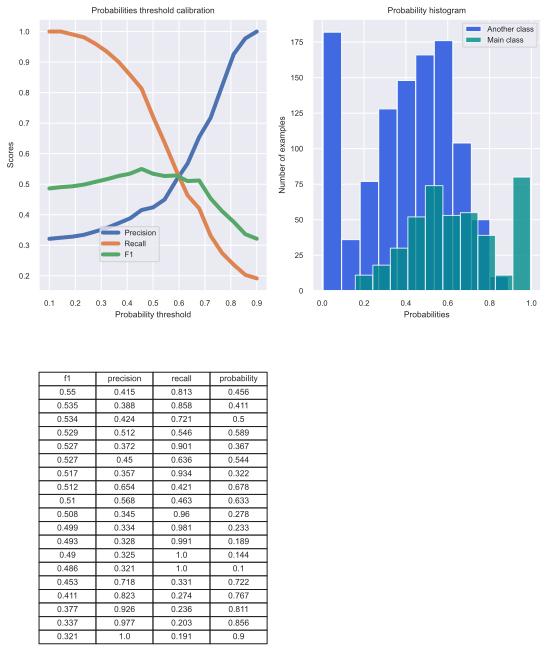

In [129]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [130]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (9, len(feature_importances) * 0.2))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

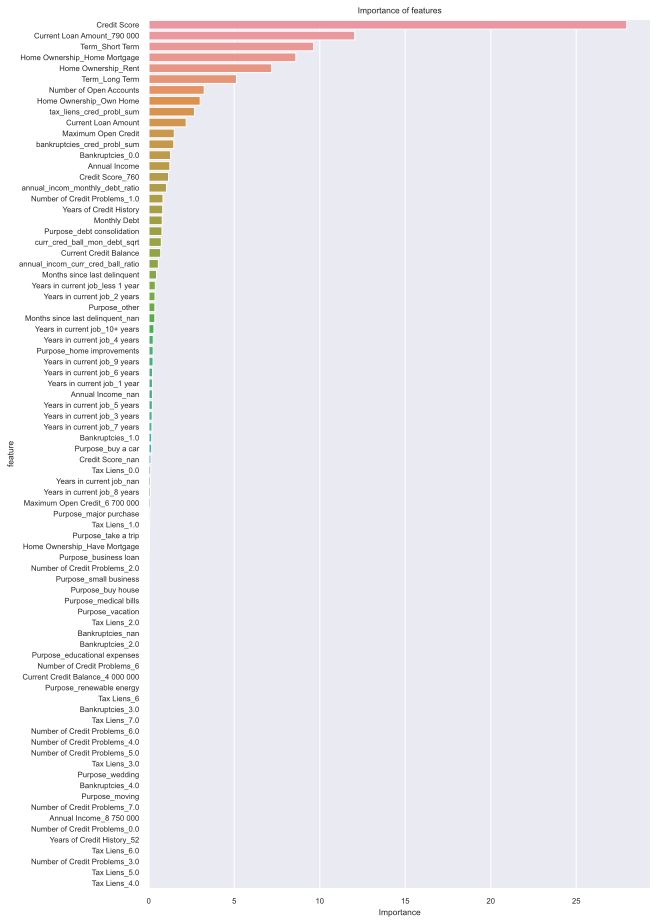

In [131]:
important_features_top = show_feature_importances(X_train_balanced.columns,
                                                  model_catb.feature_importances_, get_top=20)

In [132]:
important_features_top

['Credit Score',
 'Current Loan Amount_790 000',
 'Term_Short Term',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Rent',
 'Term_Long Term',
 'Number of Open Accounts',
 'Home Ownership_Own Home',
 'tax_liens_cred_probl_sum',
 'Current Loan Amount',
 'Maximum Open Credit',
 'bankruptcies_cred_probl_sum',
 'Bankruptcies_0.0',
 'Annual Income',
 'Credit Score_760',
 'annual_incom_monthly_debt_ratio',
 'Number of Credit Problems_1.0',
 'Years of Credit History',
 'Monthly Debt',
 'Purpose_debt consolidation']

In [133]:
CAT_FEATURE_NAMES

['Home Ownership',
 'Years in current job',
 'Tax Liens',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term']

In [134]:
value_def('Home Ownership')

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [135]:
X_train_balanced = X_train_balanced[important_features_top]
X_test = X_test[important_features_top]
test_df = test_df[important_features_top]

In [136]:
final_frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     #'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':30
}

In [137]:
params = {'iterations':[5, 7, 10, 20, 30, 50, 200, 500],
          'max_depth':[3, 5, 7, 10]}

In [138]:
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [139]:
model_catb_grid = catb.CatBoostClassifier()

In [140]:
grid_search = model_catb_grid.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6719225	test: 0.6728305	best: 0.6728305 (0)	total: 4.09ms	remaining: 16.4ms
1:	learn: 0.6597165	test: 0.6614624	best: 0.6614624 (1)	total: 6.7ms	remaining: 10ms
2:	learn: 0.6478880	test: 0.6509737	best: 0.6509737 (2)	total: 9.9ms	remaining: 6.6ms
3:	learn: 0.6364819	test: 0.6405756	best: 0.6405756 (3)	total: 13ms	remaining: 3.26ms
4:	learn: 0.6202697	test: 0.6254568	best: 0.6254568 (4)	total: 18.4ms	remaining: 0us

bestTest = 0.6254568026
bestIteration = 4

0:	loss: 0.6254568	best: 0.6254568 (0)	total: 44.3ms	remaining: 1.37s
0:	learn: 0.6719225	test: 0.6728305	best: 0.6728305 (0)	total: 36.3ms	remaining: 218ms
1:	learn: 0.6597165	test: 0.6614624	best: 0.6614624 (1)	total: 39.2ms	remaining: 98ms
2:	learn: 0.6478880	test: 0.6509737	best: 0.6509737 (2)	total: 42.1ms	remaining: 56.1ms
3:	learn: 0.6364819	test: 0.6405756	best: 0.6405756 (3)	total: 44.5ms	remaining: 33.4ms
4:	learn: 0.6202697	test: 0.6254568	best: 0.6254568 (4)	total: 47.3ms	remaining: 18.9ms
5:	learn: 0.6107312

39:	learn: 0.4915540	test: 0.5088796	best: 0.5088796 (39)	total: 106ms	remaining: 26.4ms
40:	learn: 0.4909835	test: 0.5084099	best: 0.5084099 (40)	total: 108ms	remaining: 23.8ms
41:	learn: 0.4903770	test: 0.5078569	best: 0.5078569 (41)	total: 111ms	remaining: 21.1ms
42:	learn: 0.4895814	test: 0.5071825	best: 0.5071825 (42)	total: 113ms	remaining: 18.4ms
43:	learn: 0.4890081	test: 0.5065376	best: 0.5065376 (43)	total: 116ms	remaining: 15.8ms
44:	learn: 0.4883252	test: 0.5060851	best: 0.5060851 (44)	total: 118ms	remaining: 13.2ms
45:	learn: 0.4878041	test: 0.5057251	best: 0.5057251 (45)	total: 121ms	remaining: 10.5ms
46:	learn: 0.4869253	test: 0.5048427	best: 0.5048427 (46)	total: 125ms	remaining: 7.97ms
47:	learn: 0.4864349	test: 0.5041971	best: 0.5041971 (47)	total: 128ms	remaining: 5.32ms
48:	learn: 0.4859579	test: 0.5036824	best: 0.5036824 (48)	total: 130ms	remaining: 2.65ms
49:	learn: 0.4854412	test: 0.5033904	best: 0.5033904 (49)	total: 133ms	remaining: 0us

bestTest = 0.5033904157

122:	learn: 0.4601305	test: 0.4838984	best: 0.4838724 (121)	total: 329ms	remaining: 206ms
123:	learn: 0.4600245	test: 0.4838048	best: 0.4838048 (123)	total: 331ms	remaining: 203ms
124:	learn: 0.4599404	test: 0.4837899	best: 0.4837899 (124)	total: 333ms	remaining: 200ms
125:	learn: 0.4597951	test: 0.4837914	best: 0.4837899 (124)	total: 336ms	remaining: 197ms
126:	learn: 0.4596446	test: 0.4837418	best: 0.4837418 (126)	total: 338ms	remaining: 194ms
127:	learn: 0.4591954	test: 0.4832771	best: 0.4832771 (127)	total: 341ms	remaining: 192ms
128:	learn: 0.4591209	test: 0.4832642	best: 0.4832642 (128)	total: 344ms	remaining: 189ms
129:	learn: 0.4589735	test: 0.4831894	best: 0.4831894 (129)	total: 347ms	remaining: 187ms
130:	learn: 0.4588788	test: 0.4830615	best: 0.4830615 (130)	total: 349ms	remaining: 184ms
131:	learn: 0.4587298	test: 0.4830393	best: 0.4830393 (131)	total: 352ms	remaining: 181ms
132:	learn: 0.4585930	test: 0.4828835	best: 0.4828835 (132)	total: 354ms	remaining: 178ms
133:	learn

54:	learn: 0.4829326	test: 0.5014399	best: 0.5014399 (54)	total: 144ms	remaining: 1.17s
55:	learn: 0.4826285	test: 0.5013028	best: 0.5013028 (55)	total: 147ms	remaining: 1.16s
56:	learn: 0.4818276	test: 0.5005435	best: 0.5005435 (56)	total: 149ms	remaining: 1.16s
57:	learn: 0.4806614	test: 0.4995612	best: 0.4995612 (57)	total: 152ms	remaining: 1.16s
58:	learn: 0.4795467	test: 0.4984019	best: 0.4984019 (58)	total: 155ms	remaining: 1.16s
59:	learn: 0.4792720	test: 0.4982989	best: 0.4982989 (59)	total: 159ms	remaining: 1.16s
60:	learn: 0.4778160	test: 0.4970110	best: 0.4970110 (60)	total: 161ms	remaining: 1.16s
61:	learn: 0.4773642	test: 0.4966761	best: 0.4966761 (61)	total: 164ms	remaining: 1.16s
62:	learn: 0.4770353	test: 0.4965780	best: 0.4965780 (62)	total: 166ms	remaining: 1.15s
63:	learn: 0.4764009	test: 0.4961055	best: 0.4961055 (63)	total: 168ms	remaining: 1.15s
64:	learn: 0.4752433	test: 0.4948560	best: 0.4948560 (64)	total: 171ms	remaining: 1.15s
65:	learn: 0.4741381	test: 0.493

182:	learn: 0.4518613	test: 0.4800217	best: 0.4800217 (182)	total: 504ms	remaining: 873ms
183:	learn: 0.4518030	test: 0.4800547	best: 0.4800217 (182)	total: 507ms	remaining: 870ms
184:	learn: 0.4516907	test: 0.4801023	best: 0.4800217 (182)	total: 509ms	remaining: 867ms
185:	learn: 0.4515485	test: 0.4801405	best: 0.4800217 (182)	total: 512ms	remaining: 864ms
186:	learn: 0.4512902	test: 0.4799009	best: 0.4799009 (186)	total: 514ms	remaining: 861ms
187:	learn: 0.4511510	test: 0.4799131	best: 0.4799009 (186)	total: 517ms	remaining: 858ms
188:	learn: 0.4510214	test: 0.4799067	best: 0.4799009 (186)	total: 520ms	remaining: 855ms
189:	learn: 0.4509229	test: 0.4798621	best: 0.4798621 (189)	total: 522ms	remaining: 852ms
190:	learn: 0.4507708	test: 0.4798366	best: 0.4798366 (190)	total: 525ms	remaining: 850ms
191:	learn: 0.4506810	test: 0.4798735	best: 0.4798366 (190)	total: 528ms	remaining: 847ms
192:	learn: 0.4504936	test: 0.4797165	best: 0.4797165 (192)	total: 531ms	remaining: 844ms
193:	learn

317:	learn: 0.4379492	test: 0.4772918	best: 0.4770215 (308)	total: 864ms	remaining: 494ms
318:	learn: 0.4378366	test: 0.4772584	best: 0.4770215 (308)	total: 866ms	remaining: 491ms
319:	learn: 0.4377154	test: 0.4773589	best: 0.4770215 (308)	total: 869ms	remaining: 489ms
320:	learn: 0.4376328	test: 0.4773638	best: 0.4770215 (308)	total: 872ms	remaining: 486ms
321:	learn: 0.4375811	test: 0.4773818	best: 0.4770215 (308)	total: 874ms	remaining: 483ms
322:	learn: 0.4374338	test: 0.4773186	best: 0.4770215 (308)	total: 877ms	remaining: 481ms
323:	learn: 0.4373275	test: 0.4773579	best: 0.4770215 (308)	total: 880ms	remaining: 478ms
324:	learn: 0.4372825	test: 0.4773366	best: 0.4770215 (308)	total: 884ms	remaining: 476ms
325:	learn: 0.4371481	test: 0.4772962	best: 0.4770215 (308)	total: 887ms	remaining: 473ms
326:	learn: 0.4370730	test: 0.4772230	best: 0.4770215 (308)	total: 889ms	remaining: 470ms
327:	learn: 0.4369258	test: 0.4772636	best: 0.4770215 (308)	total: 892ms	remaining: 468ms
328:	learn

447:	learn: 0.4243677	test: 0.4772576	best: 0.4766000 (363)	total: 1.22s	remaining: 142ms
448:	learn: 0.4242990	test: 0.4772814	best: 0.4766000 (363)	total: 1.22s	remaining: 139ms
449:	learn: 0.4242144	test: 0.4773531	best: 0.4766000 (363)	total: 1.23s	remaining: 136ms
450:	learn: 0.4241268	test: 0.4772927	best: 0.4766000 (363)	total: 1.23s	remaining: 134ms
451:	learn: 0.4240525	test: 0.4772024	best: 0.4766000 (363)	total: 1.23s	remaining: 131ms
452:	learn: 0.4239367	test: 0.4772800	best: 0.4766000 (363)	total: 1.23s	remaining: 128ms
453:	learn: 0.4238577	test: 0.4773149	best: 0.4766000 (363)	total: 1.24s	remaining: 125ms
454:	learn: 0.4237277	test: 0.4773170	best: 0.4766000 (363)	total: 1.24s	remaining: 123ms
455:	learn: 0.4236586	test: 0.4773702	best: 0.4766000 (363)	total: 1.24s	remaining: 120ms
456:	learn: 0.4235392	test: 0.4774166	best: 0.4766000 (363)	total: 1.25s	remaining: 117ms
457:	learn: 0.4234633	test: 0.4775013	best: 0.4766000 (363)	total: 1.25s	remaining: 114ms
458:	learn

20:	learn: 0.5214214	test: 0.5355738	best: 0.5355738 (20)	total: 73.3ms	remaining: 31.4ms
21:	learn: 0.5187399	test: 0.5333463	best: 0.5333463 (21)	total: 77.7ms	remaining: 28.3ms
22:	learn: 0.5163361	test: 0.5312716	best: 0.5312716 (22)	total: 81.3ms	remaining: 24.7ms
23:	learn: 0.5137530	test: 0.5289294	best: 0.5289294 (23)	total: 85.2ms	remaining: 21.3ms
24:	learn: 0.5098544	test: 0.5251439	best: 0.5251439 (24)	total: 88.6ms	remaining: 17.7ms
25:	learn: 0.5078860	test: 0.5234743	best: 0.5234743 (25)	total: 91.9ms	remaining: 14.1ms
26:	learn: 0.5056393	test: 0.5215477	best: 0.5215477 (26)	total: 95ms	remaining: 10.6ms
27:	learn: 0.5027516	test: 0.5189096	best: 0.5189096 (27)	total: 97.8ms	remaining: 6.99ms
28:	learn: 0.5008148	test: 0.5171997	best: 0.5171997 (28)	total: 101ms	remaining: 3.48ms
29:	learn: 0.4991733	test: 0.5159725	best: 0.5159725 (29)	total: 104ms	remaining: 0us

bestTest = 0.5159724584
bestIteration = 29

12:	loss: 0.5159725	best: 0.4766000 (7)	total: 2.67s	remaining

45:	learn: 0.4786160	test: 0.4987111	best: 0.4987111 (45)	total: 155ms	remaining: 518ms
46:	learn: 0.4779250	test: 0.4983067	best: 0.4983067 (46)	total: 158ms	remaining: 515ms
47:	learn: 0.4764410	test: 0.4969919	best: 0.4969919 (47)	total: 162ms	remaining: 512ms
48:	learn: 0.4756149	test: 0.4963059	best: 0.4963059 (48)	total: 165ms	remaining: 508ms
49:	learn: 0.4750362	test: 0.4958374	best: 0.4958374 (49)	total: 168ms	remaining: 505ms
50:	learn: 0.4745049	test: 0.4955158	best: 0.4955158 (50)	total: 172ms	remaining: 502ms
51:	learn: 0.4739222	test: 0.4950823	best: 0.4950823 (51)	total: 175ms	remaining: 498ms
52:	learn: 0.4725991	test: 0.4938117	best: 0.4938117 (52)	total: 178ms	remaining: 494ms
53:	learn: 0.4720696	test: 0.4934032	best: 0.4934032 (53)	total: 182ms	remaining: 491ms
54:	learn: 0.4707506	test: 0.4921887	best: 0.4921887 (54)	total: 185ms	remaining: 488ms
55:	learn: 0.4702484	test: 0.4920191	best: 0.4920191 (55)	total: 188ms	remaining: 485ms
56:	learn: 0.4699427	test: 0.492

151:	learn: 0.4406576	test: 0.4793161	best: 0.4792655 (149)	total: 506ms	remaining: 160ms
152:	learn: 0.4404968	test: 0.4792151	best: 0.4792151 (152)	total: 509ms	remaining: 156ms
153:	learn: 0.4403117	test: 0.4792258	best: 0.4792151 (152)	total: 513ms	remaining: 153ms
154:	learn: 0.4401819	test: 0.4791863	best: 0.4791863 (154)	total: 516ms	remaining: 150ms
155:	learn: 0.4399743	test: 0.4791387	best: 0.4791387 (155)	total: 519ms	remaining: 147ms
156:	learn: 0.4398600	test: 0.4791988	best: 0.4791387 (155)	total: 523ms	remaining: 143ms
157:	learn: 0.4396286	test: 0.4791647	best: 0.4791387 (155)	total: 526ms	remaining: 140ms
158:	learn: 0.4392735	test: 0.4788993	best: 0.4788993 (158)	total: 530ms	remaining: 137ms
159:	learn: 0.4390985	test: 0.4788250	best: 0.4788250 (159)	total: 534ms	remaining: 133ms
160:	learn: 0.4389927	test: 0.4788012	best: 0.4788012 (160)	total: 537ms	remaining: 130ms
161:	learn: 0.4388146	test: 0.4786908	best: 0.4786908 (161)	total: 541ms	remaining: 127ms
162:	learn

55:	learn: 0.4702484	test: 0.4920191	best: 0.4920191 (55)	total: 187ms	remaining: 1.48s
56:	learn: 0.4699427	test: 0.4920568	best: 0.4920191 (55)	total: 190ms	remaining: 1.48s
57:	learn: 0.4694900	test: 0.4915378	best: 0.4915378 (57)	total: 193ms	remaining: 1.47s
58:	learn: 0.4685880	test: 0.4907170	best: 0.4907170 (58)	total: 197ms	remaining: 1.47s
59:	learn: 0.4679239	test: 0.4900731	best: 0.4900731 (59)	total: 200ms	remaining: 1.46s
60:	learn: 0.4672617	test: 0.4896676	best: 0.4896676 (60)	total: 203ms	remaining: 1.46s
61:	learn: 0.4668142	test: 0.4895824	best: 0.4895824 (61)	total: 207ms	remaining: 1.46s
62:	learn: 0.4661743	test: 0.4889576	best: 0.4889576 (62)	total: 210ms	remaining: 1.46s
63:	learn: 0.4660937	test: 0.4889099	best: 0.4889099 (63)	total: 212ms	remaining: 1.44s
64:	learn: 0.4656195	test: 0.4884979	best: 0.4884979 (64)	total: 215ms	remaining: 1.44s
65:	learn: 0.4651690	test: 0.4882630	best: 0.4882630 (65)	total: 219ms	remaining: 1.44s
66:	learn: 0.4648019	test: 0.488

159:	learn: 0.4390985	test: 0.4788250	best: 0.4788250 (159)	total: 539ms	remaining: 1.14s
160:	learn: 0.4389927	test: 0.4788012	best: 0.4788012 (160)	total: 542ms	remaining: 1.14s
161:	learn: 0.4388146	test: 0.4786908	best: 0.4786908 (161)	total: 546ms	remaining: 1.14s
162:	learn: 0.4386831	test: 0.4786099	best: 0.4786099 (162)	total: 549ms	remaining: 1.14s
163:	learn: 0.4383253	test: 0.4782526	best: 0.4782526 (163)	total: 553ms	remaining: 1.13s
164:	learn: 0.4382120	test: 0.4782279	best: 0.4782279 (164)	total: 556ms	remaining: 1.13s
165:	learn: 0.4379272	test: 0.4781035	best: 0.4781035 (165)	total: 559ms	remaining: 1.12s
166:	learn: 0.4377454	test: 0.4778969	best: 0.4778969 (166)	total: 562ms	remaining: 1.12s
167:	learn: 0.4376178	test: 0.4778649	best: 0.4778649 (167)	total: 565ms	remaining: 1.12s
168:	learn: 0.4374708	test: 0.4778838	best: 0.4778649 (167)	total: 569ms	remaining: 1.11s
169:	learn: 0.4373073	test: 0.4779734	best: 0.4778649 (167)	total: 572ms	remaining: 1.11s
170:	learn

265:	learn: 0.4197246	test: 0.4750090	best: 0.4749576 (264)	total: 890ms	remaining: 783ms
266:	learn: 0.4195399	test: 0.4750234	best: 0.4749576 (264)	total: 893ms	remaining: 780ms
267:	learn: 0.4193315	test: 0.4750577	best: 0.4749576 (264)	total: 897ms	remaining: 777ms
268:	learn: 0.4191457	test: 0.4751145	best: 0.4749576 (264)	total: 901ms	remaining: 773ms
269:	learn: 0.4189452	test: 0.4750722	best: 0.4749576 (264)	total: 904ms	remaining: 770ms
270:	learn: 0.4188124	test: 0.4750156	best: 0.4749576 (264)	total: 907ms	remaining: 767ms
271:	learn: 0.4187197	test: 0.4750159	best: 0.4749576 (264)	total: 911ms	remaining: 763ms
272:	learn: 0.4186189	test: 0.4750776	best: 0.4749576 (264)	total: 914ms	remaining: 760ms
273:	learn: 0.4185253	test: 0.4750254	best: 0.4749576 (264)	total: 918ms	remaining: 757ms
274:	learn: 0.4182783	test: 0.4750984	best: 0.4749576 (264)	total: 921ms	remaining: 754ms
275:	learn: 0.4180709	test: 0.4751827	best: 0.4749576 (264)	total: 925ms	remaining: 750ms
276:	learn

366:	learn: 0.4004342	test: 0.4759419	best: 0.4747585 (312)	total: 1.24s	remaining: 449ms
367:	learn: 0.4002063	test: 0.4759741	best: 0.4747585 (312)	total: 1.24s	remaining: 446ms
368:	learn: 0.3999278	test: 0.4760284	best: 0.4747585 (312)	total: 1.25s	remaining: 442ms
369:	learn: 0.3998136	test: 0.4760264	best: 0.4747585 (312)	total: 1.25s	remaining: 439ms
370:	learn: 0.3994992	test: 0.4760235	best: 0.4747585 (312)	total: 1.25s	remaining: 436ms
371:	learn: 0.3992905	test: 0.4760297	best: 0.4747585 (312)	total: 1.26s	remaining: 433ms
372:	learn: 0.3991406	test: 0.4760963	best: 0.4747585 (312)	total: 1.26s	remaining: 429ms
373:	learn: 0.3989926	test: 0.4760329	best: 0.4747585 (312)	total: 1.26s	remaining: 426ms
374:	learn: 0.3988766	test: 0.4760034	best: 0.4747585 (312)	total: 1.27s	remaining: 423ms
375:	learn: 0.3986066	test: 0.4758885	best: 0.4747585 (312)	total: 1.27s	remaining: 419ms
376:	learn: 0.3983360	test: 0.4758015	best: 0.4747585 (312)	total: 1.27s	remaining: 416ms
377:	learn

468:	learn: 0.3802996	test: 0.4777088	best: 0.4747585 (312)	total: 1.59s	remaining: 105ms
469:	learn: 0.3801039	test: 0.4778089	best: 0.4747585 (312)	total: 1.59s	remaining: 102ms
470:	learn: 0.3799886	test: 0.4777386	best: 0.4747585 (312)	total: 1.6s	remaining: 98.3ms
471:	learn: 0.3798072	test: 0.4778202	best: 0.4747585 (312)	total: 1.6s	remaining: 94.9ms
472:	learn: 0.3796121	test: 0.4778110	best: 0.4747585 (312)	total: 1.6s	remaining: 91.5ms
473:	learn: 0.3794553	test: 0.4777339	best: 0.4747585 (312)	total: 1.61s	remaining: 88.1ms
474:	learn: 0.3792756	test: 0.4777879	best: 0.4747585 (312)	total: 1.61s	remaining: 84.7ms
475:	learn: 0.3791303	test: 0.4778012	best: 0.4747585 (312)	total: 1.61s	remaining: 81.3ms
476:	learn: 0.3790978	test: 0.4778217	best: 0.4747585 (312)	total: 1.61s	remaining: 77.9ms
477:	learn: 0.3789283	test: 0.4777223	best: 0.4747585 (312)	total: 1.62s	remaining: 74.5ms
478:	learn: 0.3788268	test: 0.4777622	best: 0.4747585 (312)	total: 1.62s	remaining: 71.1ms
479:

1:	learn: 0.6596141	test: 0.6621851	best: 0.6621851 (1)	total: 10.6ms	remaining: 253ms
2:	learn: 0.6427708	test: 0.6465415	best: 0.6465415 (2)	total: 15.6ms	remaining: 245ms
3:	learn: 0.6279534	test: 0.6331127	best: 0.6331127 (3)	total: 21.2ms	remaining: 244ms
4:	learn: 0.6150614	test: 0.6212738	best: 0.6212738 (4)	total: 26.3ms	remaining: 237ms
5:	learn: 0.6055024	test: 0.6127253	best: 0.6127253 (5)	total: 31.3ms	remaining: 229ms
6:	learn: 0.5969564	test: 0.6050892	best: 0.6050892 (6)	total: 36.6ms	remaining: 225ms
7:	learn: 0.5897012	test: 0.5984216	best: 0.5984216 (7)	total: 42.4ms	remaining: 223ms
8:	learn: 0.5823518	test: 0.5921888	best: 0.5921888 (8)	total: 47.8ms	remaining: 218ms
9:	learn: 0.5756924	test: 0.5863959	best: 0.5863959 (9)	total: 53.4ms	remaining: 214ms
10:	learn: 0.5693545	test: 0.5807616	best: 0.5807616 (10)	total: 58.9ms	remaining: 209ms
11:	learn: 0.5614766	test: 0.5735281	best: 0.5735281 (11)	total: 64.7ms	remaining: 205ms
12:	learn: 0.5550852	test: 0.5675085	be

72:	learn: 0.4513822	test: 0.4844059	best: 0.4844059 (72)	total: 431ms	remaining: 749ms
73:	learn: 0.4510168	test: 0.4842795	best: 0.4842795 (73)	total: 436ms	remaining: 742ms
74:	learn: 0.4505574	test: 0.4841279	best: 0.4841279 (74)	total: 442ms	remaining: 736ms
75:	learn: 0.4500259	test: 0.4840673	best: 0.4840673 (75)	total: 448ms	remaining: 730ms
76:	learn: 0.4492185	test: 0.4837927	best: 0.4837927 (76)	total: 454ms	remaining: 725ms
77:	learn: 0.4488117	test: 0.4836503	best: 0.4836503 (77)	total: 459ms	remaining: 719ms
78:	learn: 0.4479979	test: 0.4831408	best: 0.4831408 (78)	total: 465ms	remaining: 712ms
79:	learn: 0.4476287	test: 0.4828887	best: 0.4828887 (79)	total: 471ms	remaining: 707ms
80:	learn: 0.4471234	test: 0.4827738	best: 0.4827738 (80)	total: 477ms	remaining: 701ms
81:	learn: 0.4464584	test: 0.4825927	best: 0.4825927 (81)	total: 483ms	remaining: 695ms
82:	learn: 0.4457734	test: 0.4824549	best: 0.4824549 (82)	total: 489ms	remaining: 690ms
83:	learn: 0.4453071	test: 0.482

164:	learn: 0.4142448	test: 0.4759025	best: 0.4757672 (162)	total: 965ms	remaining: 205ms
165:	learn: 0.4138953	test: 0.4758810	best: 0.4757672 (162)	total: 971ms	remaining: 199ms
166:	learn: 0.4130312	test: 0.4758798	best: 0.4757672 (162)	total: 977ms	remaining: 193ms
167:	learn: 0.4127086	test: 0.4759070	best: 0.4757672 (162)	total: 983ms	remaining: 187ms
168:	learn: 0.4124682	test: 0.4758992	best: 0.4757672 (162)	total: 989ms	remaining: 181ms
169:	learn: 0.4122378	test: 0.4759004	best: 0.4757672 (162)	total: 994ms	remaining: 175ms
170:	learn: 0.4117521	test: 0.4759014	best: 0.4757672 (162)	total: 1s	remaining: 170ms
171:	learn: 0.4113145	test: 0.4758118	best: 0.4757672 (162)	total: 1.01s	remaining: 164ms
172:	learn: 0.4111386	test: 0.4758623	best: 0.4757672 (162)	total: 1.01s	remaining: 158ms
173:	learn: 0.4108163	test: 0.4757651	best: 0.4757651 (173)	total: 1.02s	remaining: 152ms
174:	learn: 0.4104800	test: 0.4758901	best: 0.4757651 (173)	total: 1.02s	remaining: 146ms
175:	learn: 0

86:	learn: 0.4437115	test: 0.4818980	best: 0.4818980 (86)	total: 509ms	remaining: 2.42s
87:	learn: 0.4433987	test: 0.4816801	best: 0.4816801 (87)	total: 515ms	remaining: 2.41s
88:	learn: 0.4430542	test: 0.4814592	best: 0.4814592 (88)	total: 520ms	remaining: 2.4s
89:	learn: 0.4423075	test: 0.4812880	best: 0.4812880 (89)	total: 526ms	remaining: 2.4s
90:	learn: 0.4417919	test: 0.4809926	best: 0.4809926 (90)	total: 532ms	remaining: 2.39s
91:	learn: 0.4409787	test: 0.4804624	best: 0.4804624 (91)	total: 537ms	remaining: 2.38s
92:	learn: 0.4405394	test: 0.4803914	best: 0.4803914 (92)	total: 543ms	remaining: 2.38s
93:	learn: 0.4401270	test: 0.4804328	best: 0.4803914 (92)	total: 548ms	remaining: 2.37s
94:	learn: 0.4396902	test: 0.4803569	best: 0.4803569 (94)	total: 554ms	remaining: 2.36s
95:	learn: 0.4391801	test: 0.4802904	best: 0.4802904 (95)	total: 563ms	remaining: 2.37s
96:	learn: 0.4387754	test: 0.4799807	best: 0.4799807 (96)	total: 570ms	remaining: 2.37s
97:	learn: 0.4384802	test: 0.47987

206:	learn: 0.3999645	test: 0.4745130	best: 0.4743624 (202)	total: 1.22s	remaining: 1.73s
207:	learn: 0.3996362	test: 0.4745280	best: 0.4743624 (202)	total: 1.23s	remaining: 1.72s
208:	learn: 0.3993761	test: 0.4746213	best: 0.4743624 (202)	total: 1.23s	remaining: 1.71s
209:	learn: 0.3991779	test: 0.4744752	best: 0.4743624 (202)	total: 1.24s	remaining: 1.71s
210:	learn: 0.3989373	test: 0.4741871	best: 0.4741871 (210)	total: 1.24s	remaining: 1.7s
211:	learn: 0.3985003	test: 0.4741893	best: 0.4741871 (210)	total: 1.25s	remaining: 1.7s
212:	learn: 0.3979440	test: 0.4743553	best: 0.4741871 (210)	total: 1.25s	remaining: 1.69s
213:	learn: 0.3977574	test: 0.4742926	best: 0.4741871 (210)	total: 1.26s	remaining: 1.68s
214:	learn: 0.3974132	test: 0.4742029	best: 0.4741871 (210)	total: 1.27s	remaining: 1.68s
215:	learn: 0.3970692	test: 0.4743433	best: 0.4741871 (210)	total: 1.27s	remaining: 1.67s
216:	learn: 0.3965080	test: 0.4743972	best: 0.4741871 (210)	total: 1.28s	remaining: 1.67s
217:	learn: 

299:	learn: 0.3704289	test: 0.4738753	best: 0.4735804 (296)	total: 1.76s	remaining: 1.17s
300:	learn: 0.3699406	test: 0.4738657	best: 0.4735804 (296)	total: 1.76s	remaining: 1.17s
301:	learn: 0.3696156	test: 0.4737156	best: 0.4735804 (296)	total: 1.77s	remaining: 1.16s
302:	learn: 0.3694877	test: 0.4737688	best: 0.4735804 (296)	total: 1.77s	remaining: 1.15s
303:	learn: 0.3690677	test: 0.4738239	best: 0.4735804 (296)	total: 1.78s	remaining: 1.15s
304:	learn: 0.3687501	test: 0.4738202	best: 0.4735804 (296)	total: 1.78s	remaining: 1.14s
305:	learn: 0.3685244	test: 0.4739160	best: 0.4735804 (296)	total: 1.79s	remaining: 1.14s
306:	learn: 0.3682248	test: 0.4738870	best: 0.4735804 (296)	total: 1.8s	remaining: 1.13s
307:	learn: 0.3679706	test: 0.4738862	best: 0.4735804 (296)	total: 1.8s	remaining: 1.12s
308:	learn: 0.3675488	test: 0.4738709	best: 0.4735804 (296)	total: 1.81s	remaining: 1.12s
309:	learn: 0.3671810	test: 0.4740977	best: 0.4735804 (296)	total: 1.81s	remaining: 1.11s
310:	learn: 

391:	learn: 0.3402934	test: 0.4752735	best: 0.4735804 (296)	total: 2.29s	remaining: 631ms
392:	learn: 0.3400377	test: 0.4751639	best: 0.4735804 (296)	total: 2.3s	remaining: 625ms
393:	learn: 0.3397797	test: 0.4751076	best: 0.4735804 (296)	total: 2.3s	remaining: 619ms
394:	learn: 0.3394589	test: 0.4751430	best: 0.4735804 (296)	total: 2.31s	remaining: 614ms
395:	learn: 0.3392545	test: 0.4751224	best: 0.4735804 (296)	total: 2.31s	remaining: 608ms
396:	learn: 0.3390140	test: 0.4750791	best: 0.4735804 (296)	total: 2.32s	remaining: 602ms
397:	learn: 0.3388921	test: 0.4750545	best: 0.4735804 (296)	total: 2.33s	remaining: 596ms
398:	learn: 0.3383991	test: 0.4752072	best: 0.4735804 (296)	total: 2.33s	remaining: 590ms
399:	learn: 0.3383123	test: 0.4752577	best: 0.4735804 (296)	total: 2.34s	remaining: 584ms
400:	learn: 0.3380220	test: 0.4752480	best: 0.4735804 (296)	total: 2.34s	remaining: 578ms
401:	learn: 0.3378519	test: 0.4751794	best: 0.4735804 (296)	total: 2.35s	remaining: 572ms
402:	learn: 

3:	learn: 0.6272688	test: 0.6328994	best: 0.6328994 (3)	total: 133ms	remaining: 33.2ms
4:	learn: 0.6170524	test: 0.6242550	best: 0.6242550 (4)	total: 166ms	remaining: 0us

bestTest = 0.624254997
bestIteration = 4

24:	loss: 0.6242550	best: 0.4735804 (23)	total: 10.6s	remaining: 2.97s
0:	learn: 0.6739171	test: 0.6753365	best: 0.6753365 (0)	total: 35.7ms	remaining: 214ms
1:	learn: 0.6560569	test: 0.6586385	best: 0.6586385 (1)	total: 71.8ms	remaining: 179ms
2:	learn: 0.6412381	test: 0.6460399	best: 0.6460399 (2)	total: 109ms	remaining: 145ms
3:	learn: 0.6272688	test: 0.6328994	best: 0.6328994 (3)	total: 145ms	remaining: 109ms
4:	learn: 0.6170524	test: 0.6242550	best: 0.6242550 (4)	total: 180ms	remaining: 72.1ms
5:	learn: 0.6069844	test: 0.6163943	best: 0.6163943 (5)	total: 217ms	remaining: 36.1ms
6:	learn: 0.5967502	test: 0.6076486	best: 0.6076486 (6)	total: 254ms	remaining: 0us

bestTest = 0.6076486347
bestIteration = 6

25:	loss: 0.6076486	best: 0.4735804 (23)	total: 10.9s	remaining: 2.

22:	learn: 0.5007499	test: 0.5255973	best: 0.5255973 (22)	total: 763ms	remaining: 896ms
23:	learn: 0.4975408	test: 0.5235694	best: 0.5235694 (23)	total: 799ms	remaining: 865ms
24:	learn: 0.4939492	test: 0.5213938	best: 0.5213938 (24)	total: 833ms	remaining: 833ms
25:	learn: 0.4912570	test: 0.5196109	best: 0.5196109 (25)	total: 866ms	remaining: 800ms
26:	learn: 0.4881656	test: 0.5180591	best: 0.5180591 (26)	total: 902ms	remaining: 768ms
27:	learn: 0.4855621	test: 0.5162712	best: 0.5162712 (27)	total: 938ms	remaining: 737ms
28:	learn: 0.4819711	test: 0.5137757	best: 0.5137757 (28)	total: 973ms	remaining: 705ms
29:	learn: 0.4799073	test: 0.5120649	best: 0.5120649 (29)	total: 1.01s	remaining: 672ms
30:	learn: 0.4768786	test: 0.5094464	best: 0.5094464 (30)	total: 1.04s	remaining: 640ms
31:	learn: 0.4747610	test: 0.5084569	best: 0.5084569 (31)	total: 1.08s	remaining: 608ms
32:	learn: 0.4724504	test: 0.5072554	best: 0.5072554 (32)	total: 1.12s	remaining: 576ms
33:	learn: 0.4703523	test: 0.506

65:	learn: 0.4219746	test: 0.4867598	best: 0.4867598 (65)	total: 2.25s	remaining: 4.57s
66:	learn: 0.4209085	test: 0.4861069	best: 0.4861069 (66)	total: 2.29s	remaining: 4.54s
67:	learn: 0.4201197	test: 0.4859133	best: 0.4859133 (67)	total: 2.32s	remaining: 4.51s
68:	learn: 0.4190924	test: 0.4855824	best: 0.4855824 (68)	total: 2.36s	remaining: 4.48s
69:	learn: 0.4179682	test: 0.4852745	best: 0.4852745 (69)	total: 2.4s	remaining: 4.45s
70:	learn: 0.4171637	test: 0.4850402	best: 0.4850402 (70)	total: 2.43s	remaining: 4.42s
71:	learn: 0.4166372	test: 0.4849054	best: 0.4849054 (71)	total: 2.47s	remaining: 4.39s
72:	learn: 0.4156717	test: 0.4847362	best: 0.4847362 (72)	total: 2.5s	remaining: 4.36s
73:	learn: 0.4148920	test: 0.4840868	best: 0.4840868 (73)	total: 2.54s	remaining: 4.32s
74:	learn: 0.4137292	test: 0.4842891	best: 0.4840868 (73)	total: 2.58s	remaining: 4.29s
75:	learn: 0.4125067	test: 0.4841088	best: 0.4840868 (73)	total: 2.61s	remaining: 4.26s
76:	learn: 0.4111723	test: 0.48414

158:	learn: 0.3488043	test: 0.4800369	best: 0.4800369 (158)	total: 5.74s	remaining: 1.48s
159:	learn: 0.3474137	test: 0.4803024	best: 0.4800369 (158)	total: 5.78s	remaining: 1.44s
160:	learn: 0.3471218	test: 0.4803933	best: 0.4800369 (158)	total: 5.82s	remaining: 1.41s
161:	learn: 0.3466430	test: 0.4805169	best: 0.4800369 (158)	total: 5.86s	remaining: 1.37s
162:	learn: 0.3454590	test: 0.4802641	best: 0.4800369 (158)	total: 5.89s	remaining: 1.34s
163:	learn: 0.3448389	test: 0.4803161	best: 0.4800369 (158)	total: 5.93s	remaining: 1.3s
164:	learn: 0.3441756	test: 0.4802572	best: 0.4800369 (158)	total: 5.96s	remaining: 1.26s
165:	learn: 0.3436990	test: 0.4801589	best: 0.4800369 (158)	total: 6s	remaining: 1.23s
166:	learn: 0.3427287	test: 0.4800712	best: 0.4800369 (158)	total: 6.03s	remaining: 1.19s
167:	learn: 0.3424735	test: 0.4801785	best: 0.4800369 (158)	total: 6.07s	remaining: 1.16s
168:	learn: 0.3418841	test: 0.4800901	best: 0.4800369 (158)	total: 6.1s	remaining: 1.12s
169:	learn: 0.3

51:	learn: 0.4403227	test: 0.4914220	best: 0.4914220 (51)	total: 1.82s	remaining: 15.7s
52:	learn: 0.4385847	test: 0.4915349	best: 0.4914220 (51)	total: 1.85s	remaining: 15.6s
53:	learn: 0.4377603	test: 0.4913942	best: 0.4913942 (53)	total: 1.89s	remaining: 15.6s
54:	learn: 0.4362136	test: 0.4911814	best: 0.4911814 (54)	total: 1.92s	remaining: 15.5s
55:	learn: 0.4345621	test: 0.4906784	best: 0.4906784 (55)	total: 1.95s	remaining: 15.5s
56:	learn: 0.4323827	test: 0.4905917	best: 0.4905917 (56)	total: 1.99s	remaining: 15.5s
57:	learn: 0.4311577	test: 0.4899159	best: 0.4899159 (57)	total: 2.02s	remaining: 15.4s
58:	learn: 0.4295098	test: 0.4895202	best: 0.4895202 (58)	total: 2.06s	remaining: 15.4s
59:	learn: 0.4286373	test: 0.4890156	best: 0.4890156 (59)	total: 2.1s	remaining: 15.4s
60:	learn: 0.4272905	test: 0.4886824	best: 0.4886824 (60)	total: 2.14s	remaining: 15.4s
61:	learn: 0.4264105	test: 0.4883161	best: 0.4883161 (61)	total: 2.17s	remaining: 15.4s
62:	learn: 0.4256213	test: 0.4882

147:	learn: 0.3552412	test: 0.4804870	best: 0.4801687 (128)	total: 5.22s	remaining: 12.4s
148:	learn: 0.3544344	test: 0.4804530	best: 0.4801687 (128)	total: 5.25s	remaining: 12.4s
149:	learn: 0.3539321	test: 0.4804234	best: 0.4801687 (128)	total: 5.29s	remaining: 12.3s
150:	learn: 0.3534211	test: 0.4803506	best: 0.4801687 (128)	total: 5.32s	remaining: 12.3s
151:	learn: 0.3527255	test: 0.4802324	best: 0.4801687 (128)	total: 5.35s	remaining: 12.3s
152:	learn: 0.3517580	test: 0.4802318	best: 0.4801687 (128)	total: 5.39s	remaining: 12.2s
153:	learn: 0.3512563	test: 0.4801381	best: 0.4801381 (153)	total: 5.42s	remaining: 12.2s
154:	learn: 0.3507688	test: 0.4801617	best: 0.4801381 (153)	total: 5.46s	remaining: 12.1s
155:	learn: 0.3504148	test: 0.4801224	best: 0.4801224 (155)	total: 5.49s	remaining: 12.1s
156:	learn: 0.3500100	test: 0.4801760	best: 0.4801224 (155)	total: 5.53s	remaining: 12.1s
157:	learn: 0.3495107	test: 0.4800481	best: 0.4800481 (157)	total: 5.56s	remaining: 12s
158:	learn: 

239:	learn: 0.3024734	test: 0.4805005	best: 0.4794962 (225)	total: 8.33s	remaining: 9.02s
240:	learn: 0.3015928	test: 0.4806533	best: 0.4794962 (225)	total: 8.36s	remaining: 8.99s
241:	learn: 0.3010058	test: 0.4807859	best: 0.4794962 (225)	total: 8.4s	remaining: 8.95s
242:	learn: 0.3007262	test: 0.4806797	best: 0.4794962 (225)	total: 8.43s	remaining: 8.92s
243:	learn: 0.3000788	test: 0.4807498	best: 0.4794962 (225)	total: 8.46s	remaining: 8.88s
244:	learn: 0.2995837	test: 0.4809587	best: 0.4794962 (225)	total: 8.5s	remaining: 8.85s
245:	learn: 0.2992062	test: 0.4809736	best: 0.4794962 (225)	total: 8.53s	remaining: 8.81s
246:	learn: 0.2984862	test: 0.4808282	best: 0.4794962 (225)	total: 8.57s	remaining: 8.78s
247:	learn: 0.2978399	test: 0.4809645	best: 0.4794962 (225)	total: 8.61s	remaining: 8.74s
248:	learn: 0.2970346	test: 0.4810423	best: 0.4794962 (225)	total: 8.64s	remaining: 8.71s
249:	learn: 0.2965062	test: 0.4809915	best: 0.4794962 (225)	total: 8.68s	remaining: 8.68s
250:	learn: 

333:	learn: 0.2544207	test: 0.4834017	best: 0.4794962 (225)	total: 11.5s	remaining: 5.74s
334:	learn: 0.2540122	test: 0.4834364	best: 0.4794962 (225)	total: 11.6s	remaining: 5.7s
335:	learn: 0.2534136	test: 0.4834042	best: 0.4794962 (225)	total: 11.6s	remaining: 5.67s
336:	learn: 0.2526476	test: 0.4836374	best: 0.4794962 (225)	total: 11.7s	remaining: 5.64s
337:	learn: 0.2518232	test: 0.4838036	best: 0.4794962 (225)	total: 11.7s	remaining: 5.6s
338:	learn: 0.2512727	test: 0.4839563	best: 0.4794962 (225)	total: 11.7s	remaining: 5.57s
339:	learn: 0.2510173	test: 0.4838677	best: 0.4794962 (225)	total: 11.8s	remaining: 5.53s
340:	learn: 0.2504033	test: 0.4839311	best: 0.4794962 (225)	total: 11.8s	remaining: 5.5s
341:	learn: 0.2500286	test: 0.4840234	best: 0.4794962 (225)	total: 11.8s	remaining: 5.46s
342:	learn: 0.2493693	test: 0.4841098	best: 0.4794962 (225)	total: 11.9s	remaining: 5.43s
343:	learn: 0.2490960	test: 0.4841477	best: 0.4794962 (225)	total: 11.9s	remaining: 5.39s
344:	learn: 0

428:	learn: 0.2103330	test: 0.4881467	best: 0.4794962 (225)	total: 14.8s	remaining: 2.45s
429:	learn: 0.2095938	test: 0.4883048	best: 0.4794962 (225)	total: 14.8s	remaining: 2.42s
430:	learn: 0.2094536	test: 0.4882901	best: 0.4794962 (225)	total: 14.9s	remaining: 2.38s
431:	learn: 0.2090003	test: 0.4883149	best: 0.4794962 (225)	total: 14.9s	remaining: 2.35s
432:	learn: 0.2085879	test: 0.4885150	best: 0.4794962 (225)	total: 14.9s	remaining: 2.31s
433:	learn: 0.2083701	test: 0.4885466	best: 0.4794962 (225)	total: 15s	remaining: 2.28s
434:	learn: 0.2081386	test: 0.4883984	best: 0.4794962 (225)	total: 15s	remaining: 2.24s
435:	learn: 0.2077536	test: 0.4885430	best: 0.4794962 (225)	total: 15s	remaining: 2.21s
436:	learn: 0.2072643	test: 0.4886085	best: 0.4794962 (225)	total: 15.1s	remaining: 2.17s
437:	learn: 0.2070300	test: 0.4884341	best: 0.4794962 (225)	total: 15.1s	remaining: 2.14s
438:	learn: 0.2068691	test: 0.4884838	best: 0.4794962 (225)	total: 15.2s	remaining: 2.1s
439:	learn: 0.206

28:	learn: 0.5019092	test: 0.5081766	best: 0.5081766 (28)
29:	learn: 0.5000298	test: 0.5065159	best: 0.5065159 (29)
30:	learn: 0.4982729	test: 0.5050178	best: 0.5050178 (30)
31:	learn: 0.4963590	test: 0.5034356	best: 0.5034356 (31)
32:	learn: 0.4936930	test: 0.5010259	best: 0.5010259 (32)
33:	learn: 0.4916000	test: 0.4993831	best: 0.4993831 (33)
34:	learn: 0.4901303	test: 0.4981706	best: 0.4981706 (34)
35:	learn: 0.4882849	test: 0.4966061	best: 0.4966061 (35)
36:	learn: 0.4862530	test: 0.4949336	best: 0.4949336 (36)
37:	learn: 0.4845129	test: 0.4936752	best: 0.4936752 (37)
38:	learn: 0.4832090	test: 0.4927987	best: 0.4927987 (38)
39:	learn: 0.4820669	test: 0.4921222	best: 0.4921222 (39)
40:	learn: 0.4809070	test: 0.4914099	best: 0.4914099 (40)
41:	learn: 0.4798095	test: 0.4907738	best: 0.4907738 (41)
42:	learn: 0.4788217	test: 0.4900697	best: 0.4900697 (42)
43:	learn: 0.4772734	test: 0.4888452	best: 0.4888452 (43)
44:	learn: 0.4757912	test: 0.4875901	best: 0.4875901 (44)
45:	learn: 0.4

210:	learn: 0.3908829	test: 0.4640646	best: 0.4640646 (210)
211:	learn: 0.3906134	test: 0.4640307	best: 0.4640307 (211)
212:	learn: 0.3902268	test: 0.4639784	best: 0.4639784 (212)
213:	learn: 0.3898809	test: 0.4639410	best: 0.4639410 (213)
214:	learn: 0.3893931	test: 0.4639294	best: 0.4639294 (214)
215:	learn: 0.3890823	test: 0.4639137	best: 0.4639137 (215)
216:	learn: 0.3887451	test: 0.4638903	best: 0.4638903 (216)
217:	learn: 0.3884279	test: 0.4639339	best: 0.4638903 (216)
218:	learn: 0.3881473	test: 0.4638911	best: 0.4638903 (216)
219:	learn: 0.3877109	test: 0.4638653	best: 0.4638653 (219)
220:	learn: 0.3875236	test: 0.4638466	best: 0.4638466 (220)
221:	learn: 0.3872002	test: 0.4638813	best: 0.4638466 (220)
222:	learn: 0.3868065	test: 0.4639196	best: 0.4638466 (220)
223:	learn: 0.3864975	test: 0.4639120	best: 0.4638466 (220)
224:	learn: 0.3862480	test: 0.4638599	best: 0.4638466 (220)
225:	learn: 0.3859360	test: 0.4638398	best: 0.4638398 (225)
226:	learn: 0.3856316	test: 0.4638661	be

398:	learn: 0.3257212	test: 0.4660679	best: 0.4636438 (235)
399:	learn: 0.3254223	test: 0.4660749	best: 0.4636438 (235)
400:	learn: 0.3251217	test: 0.4660865	best: 0.4636438 (235)
401:	learn: 0.3247370	test: 0.4660564	best: 0.4636438 (235)
402:	learn: 0.3244591	test: 0.4660647	best: 0.4636438 (235)
403:	learn: 0.3240642	test: 0.4659988	best: 0.4636438 (235)
404:	learn: 0.3237017	test: 0.4660383	best: 0.4636438 (235)
405:	learn: 0.3232675	test: 0.4660658	best: 0.4636438 (235)
406:	learn: 0.3229404	test: 0.4659869	best: 0.4636438 (235)
407:	learn: 0.3225737	test: 0.4660013	best: 0.4636438 (235)
408:	learn: 0.3224373	test: 0.4659913	best: 0.4636438 (235)
409:	learn: 0.3221734	test: 0.4659960	best: 0.4636438 (235)
410:	learn: 0.3217912	test: 0.4660166	best: 0.4636438 (235)
411:	learn: 0.3214234	test: 0.4660936	best: 0.4636438 (235)
412:	learn: 0.3211904	test: 0.4661105	best: 0.4636438 (235)
413:	learn: 0.3208855	test: 0.4661943	best: 0.4636438 (235)
414:	learn: 0.3204577	test: 0.4662396	be

In [141]:
final_model_catb = catb.CatBoostClassifier(**frozen_params, iterations=400, max_depth=3, #ignored_features=CAT_FEATURE_NAMES, 
                                    one_hot_max_size=10, subsample=0.65, reg_lambda=0.9, min_data_in_leaf=7)

final_model_catb.fit(X_train_balanced[important_features_top], y_train_balanced, plot=True, 
                     eval_set=(X_train_balanced, y_train_balanced))

evaluate_preds(final_model_catb, X_train_balanced[important_features_top], X_test[important_features_top], 
               y_train_balanced, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.51      0.64      3688
           1       0.65      0.93      0.77      3688

    accuracy                           0.72      7376
   macro avg       0.76      0.72      0.70      7376
weighted avg       0.76      0.72      0.70      7376

TEST

              precision    recall  f1-score   support

           0       0.87      0.47      0.61      1077
           1       0.38      0.82      0.52       423

    accuracy                           0.57      1500
   macro avg       0.62      0.65      0.57      1500
weighted avg       0.73      0.57      0.59      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               510  567
1                77  346


In [142]:
model_catb.feature_importances_

array([1.27005570e-01, 2.52990409e-01, 0.00000000e+00, 1.73169165e-01,
       9.57153634e-04, 0.00000000e+00, 1.02404937e-01, 0.00000000e+00,
       6.65134222e-02, 1.57254296e-02, 3.62033329e-01, 3.85775801e-01,
       0.00000000e+00, 3.24399231e+00, 1.28178340e+00, 0.00000000e+00,
       4.72119854e-02, 1.30882419e-03, 2.64154007e-01, 0.00000000e+00,
       0.00000000e+00, 8.21570847e-01, 2.57790730e-01, 1.15793344e+00,
       1.87800145e-01, 3.14872413e-03, 0.00000000e+00, 3.05804723e-01,
       2.17451995e-01, 5.51292777e-02, 7.03683873e-01, 2.18872496e+00,
       0.00000000e+00, 2.17914732e-01, 0.00000000e+00, 2.28591056e-01,
       1.02821900e-02, 1.49407640e+00, 5.12951855e+00, 4.93158917e-02,
       1.80130753e-03, 1.56442482e-03, 7.35082888e-01, 1.14712922e-01,
       1.20436911e+01, 2.79550988e+01, 6.72948647e-04, 3.51393503e-04,
       1.43846786e-04, 0.00000000e+00, 1.03758828e+00, 5.63251059e-01,
       0.00000000e+00, 2.40706527e-03, 1.99133123e-01, 7.14981359e-03,
      

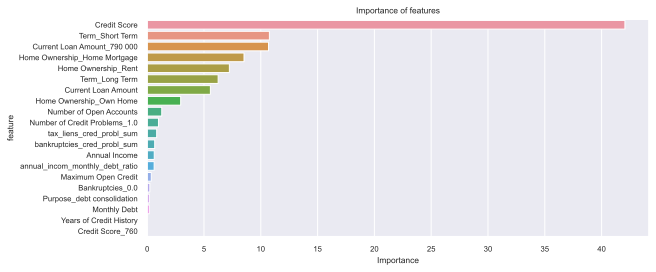

In [143]:
important_features_top = show_feature_importances(X_train_balanced[important_features_top].columns,
                                                  final_model_catb.feature_importances_, get_top=20)

In [144]:
?LGBMClassifier

Object `LGBMClassifier` not found.


In [145]:
model_lgbm = lgbm.LGBMClassifier(random_state=21,
                                 n_estimators=30,
                                 max_depth=7,
                                 min_child_samples=3)
model_lgbm.fit(X_train_balanced[important_features_top], y_train_balanced)

evaluate_preds(model_lgbm, X_train_balanced[important_features_top], X_test[important_features_top], 
               y_train_balanced, y_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
TRAIN

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      3688
           1       0.89      0.75      0.81      3688

    accuracy                           0.83      7376
   macro avg       0.84      0.83      0.83      7376
weighted avg       0.84      0.83      0.83      7376

TEST

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1077
           1       0.56      0.44      0.49       423

    accuracy                           0.75      1500
   macro avg       0.68      0.65      0.66      1500
weighted avg       0.73      0.75      0.74      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               934  143
1               238  185


In [146]:
model_br = BaggingClassifier(base_estimator=final_model_catb,
                      n_estimators=100,
                      max_samples=1.0,
                      max_features=0.9,
                      random_state=12,
                             bootstrap=True,
                             oob_score=True,
                      n_jobs=-1)
model_br.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_br, X_train_balanced, X_test, 
               y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.59      0.71      3688
           1       0.69      0.92      0.79      3688

    accuracy                           0.75      7376
   macro avg       0.79      0.75      0.75      7376
weighted avg       0.79      0.75      0.75      7376

TEST

              precision    recall  f1-score   support

           0       0.87      0.55      0.67      1077
           1       0.41      0.79      0.54       423

    accuracy                           0.61      1500
   macro avg       0.64      0.67      0.60      1500
weighted avg       0.74      0.61      0.63      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               587  490
1                88  335


In [147]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                               n_estimators=30,
                                 max_depth=7,
                                 min_child_samples=3)
model_xgb.fit(X_train_balanced[important_features_top], y_train_balanced)

evaluate_preds(model_lgbm, X_train_balanced[important_features_top], X_test[important_features_top], 
               y_train_balanced, y_test)

[01:07:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:07:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      3688
           1       0.89      0.75      0.81      3688

    accuracy                           0.83      7376
   macro avg       0.84      0.83      0.83      7376
weighted avg    

In [149]:
y_test_preds = model_br.predict_proba(test_df)

In [150]:
y_test_prob = y_test_preds[:, 1]

y_test_prob = [1 if el >= 0.5 else 0 for el in y_test_prob]

In [151]:
y_test_proba = np.array(y_test_prob)
y_test_proba

array([1, 1, 1, ..., 1, 1, 1])

In [152]:
y_test_preds = y_test_proba

In [153]:
result = pd.DataFrame()
result['Id'] = test_df.index
result['Credit Default'] = pd.Series(y_test_preds)

In [154]:
result.to_csv('catb_1.csv', index=False)
result.values

array([[   0,    1],
       [   1,    1],
       [   2,    1],
       ...,
       [2497,    1],
       [2498,    1],
       [2499,    1]], dtype=int64)

In [155]:
!pip list

Package                            Version
---------------------------------- -------------------
adjdatatools                       0.4.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.0.post1
bcrypt                             3.2.0
beautifulsoup4                     

In [156]:
!conda list

# packages in environment at C:\Users\mrbra\anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py38_0  
adjdatatools              0.4.0                    pypi_0    pypi
alabaster                 0.7.12                     py_0  
anaconda                  2020.11                  py38_0  
anaconda-client           1.7.2                    py38_0  
anaconda-navigator        1.10.0                   py38_0  
anaconda-project          0.8.4                      py_0  
argh                      0.26.2                   py38_0  
argon2-cffi               20.1.0           py38he774522_1  
asn1crypto                1.4.0                      py_0  
astroid                   2.4.2                    py38_0  
astropy                   4.0.2            py38he774522_0  
async_generator           1.10                       py_0  
atomicwrites              1.4.0                      py_0  
attrs                     20.3